In [1]:
from __future__ import print_function, division
import tarfile
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO
import cv2
from PIL import Image

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
class pic(): # Define a Class to do some pre operations of images 
  def __init__(self, filename):
    self.filename = filename;
    self.width = 120 # image width
    self.height = 48 # image height
    self.name_list, self.file_list = self.untar(self.filename)
    self.data_set = self.getdataset(self.file_list)
  
  def untar(self, filename): # uncompress the tar.gz file
    name_list = []
    file_list = []
    with tarfile.open(filename, "r") as file:
        for i in file.getmembers(): # use tar file module to untar the file
            f = file.extractfile(i)
            if f is not None:
              content = f.read()
              name_list.append(i.name)
              file_list.append(content)
    
    return name_list, file_list # return the file name list and file list

  def getdataset(self, file_list): # get data_set with np.array format
    data_set = []
    for i in range(len(file_list)):
      try:
        im = Image.open(BytesIO(file_list[i]))  # file_list is the binary stream, that needs to transfer to image format
      except OSError:
        pass
      im = im.convert("L") # convert images to gray scale
      data = im.getdata()  # get image tuple
      data = np.matrix(data)  # turn the image tuple to matrix
      
      try:
        picture = np.reshape(data,(self.height, self.width))  # turn to numpy array
      except ValueError:
        pass
      left, right = self.splitpic(picture) # split the image to enlarge the data_set
      data_set.append(left)
      data_set.append(right)
    return np.array(data_set)

  def showim(self,picture): # show image
    plt.imshow(picture)
    plt.show()

  def splitpic(self,picture): # split the image
    return np.split(picture, 2, axis=1)[0], np.split(picture, 2, axis=1)[1]
  
  def gendataset(self): # return the data_set
    return self.data_set

In [0]:
class DCGAN():
    def __init__(self):
        self.img_height = 48
        self.img_width = 60
        self.channels = 1
        self.img_shape = (self.img_height, self.img_width, self.channels)
        self.latent_dim = 100

        # Define optimizer
        optimizer = Adam(0.0002, 0.5)

        # Build the generator
        self.generator = self._generator()
        
        # Build discrimnator
        self.discriminator = self._discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Noise as input
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # In order to train G, we need to fix D
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        real = self.discriminator(img)

        # combine the generator and discriminator
        # Trains the generator to fool the discriminator
        self.combined = Model(z, real)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def _generator(self):

        moment = 0.5
        model = Sequential()

        model.add(Dense(1024 * 12 * 15, activation="relu", input_dim=self.latent_dim))
        model.add(BatchNormalization(momentum=moment))
        model.add(Activation("relu"))
        model.add(Reshape((12, 15, 1024)))
        
        model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=moment))
        model.add(Activation("relu"))
        
        model.add(Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=moment))
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=moment))
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(64, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=moment))
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(32, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=moment))
        model.add(Activation('relu'))
        
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def _discriminator(self):

        dropout = 0.6
        
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, data_set, batch_size=128, save_interval=50):
        
        data_set = data_set / 127.5 - 1. # Rescale -1 to 1
        data_set = np.expand_dims(data_set, axis=3)

        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # Train D
            idx = np.random.randint(0, data_set.shape[0], batch_size)
            imgs = data_set[idx]

            # Noise as input and get generated image 
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train G

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, real)

            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            if epoch % save_interval == 0:
                self.show_imgs(epoch)

    def show_imgs(self, epoch):
        # Generate 3*3
        noise = np.random.normal(0, 1, (3 * 3, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(3, 3)
        current = 0
        for i in range(3):
            for j in range(3):
                axs[i,j].imshow(gen_imgs[current, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                current += 1
        plt.show()
        plt.close()
    
    def dataset(self, data_set):
      data_set = self.getdataset(file_list, 48, 120)
      return data_set
      

In [0]:
pic1 = pic('yzm1.tar.gz')
data_set1 = pic1.gendataset()

In [6]:
# pic1.showim(data_set[0])
print (data_set1.shape)

(10694, 48, 60)


In [0]:
pic2 = pic('yzm.tar.gz')

In [11]:
data_set2 = pic2.gendataset()
print (data_set2.shape)

(8162, 48, 60)


In [12]:
data_set = np.concatenate((data_set1, data_set2), axis = 0)
print(data_set.shape)

(18856, 48, 60)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 184320)            18616320  
_________________________________________________________________
batch_normalization_32 (Batc (None, 184320)            737280    
_________________________________________________________________
activation_25 (Activation)   (None, 184320)            0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 12, 15, 1024)      0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 24, 30, 512)       4719104   
_________________________________________________________________
batch_normalization_33 (Batc (None, 24, 30, 512)       2048      
_________________________________________________________________
activation_26 (Activation)   (None, 24, 30, 512)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.425064] [G loss: 0.529623]


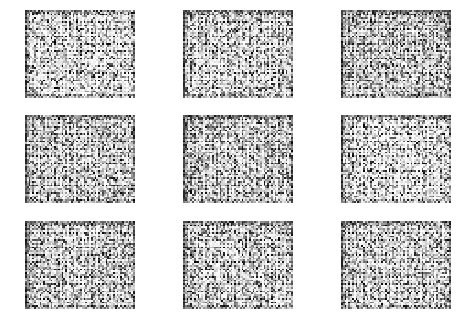

1 [D loss: 0.990192] [G loss: 1.126018]
2 [D loss: 0.864376] [G loss: 1.523127]
3 [D loss: 1.080381] [G loss: 1.131085]
4 [D loss: 0.831843] [G loss: 1.346206]
5 [D loss: 0.842471] [G loss: 1.476303]
6 [D loss: 0.578281] [G loss: 1.515844]
7 [D loss: 0.634547] [G loss: 1.312326]
8 [D loss: 1.008366] [G loss: 1.297881]
9 [D loss: 0.633554] [G loss: 1.643303]
10 [D loss: 0.637757] [G loss: 1.548557]
11 [D loss: 0.676440] [G loss: 1.843663]
12 [D loss: 0.781453] [G loss: 1.173422]
13 [D loss: 0.760859] [G loss: 1.614511]
14 [D loss: 0.572053] [G loss: 1.838058]
15 [D loss: 0.653711] [G loss: 1.782525]
16 [D loss: 0.681820] [G loss: 1.879604]
17 [D loss: 0.468480] [G loss: 2.123920]
18 [D loss: 0.686456] [G loss: 2.309390]
19 [D loss: 0.581067] [G loss: 1.748913]
20 [D loss: 0.679258] [G loss: 1.656526]
21 [D loss: 0.698763] [G loss: 1.932187]
22 [D loss: 0.531300] [G loss: 1.934672]
23 [D loss: 0.491895] [G loss: 1.766423]
24 [D loss: 0.875885] [G loss: 2.100568]
25 [D loss: 0.729364] [G 

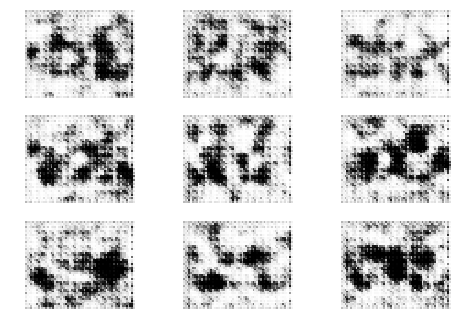

51 [D loss: 0.946086] [G loss: 1.561481]
52 [D loss: 1.008696] [G loss: 1.564384]
53 [D loss: 0.801129] [G loss: 1.746719]
54 [D loss: 1.199376] [G loss: 2.034137]
55 [D loss: 1.040004] [G loss: 1.733988]
56 [D loss: 1.027445] [G loss: 0.943287]
57 [D loss: 1.074699] [G loss: 1.536048]
58 [D loss: 0.802485] [G loss: 1.469460]
59 [D loss: 1.117464] [G loss: 1.716299]
60 [D loss: 1.057060] [G loss: 1.464702]
61 [D loss: 1.194947] [G loss: 1.679508]
62 [D loss: 0.871796] [G loss: 1.344518]
63 [D loss: 1.092353] [G loss: 0.917854]
64 [D loss: 1.202370] [G loss: 1.659506]
65 [D loss: 1.306399] [G loss: 1.523782]
66 [D loss: 1.397678] [G loss: 1.658230]
67 [D loss: 1.386276] [G loss: 1.127424]
68 [D loss: 1.027648] [G loss: 1.377596]
69 [D loss: 0.933109] [G loss: 1.100541]
70 [D loss: 1.100397] [G loss: 1.249128]
71 [D loss: 1.074908] [G loss: 1.647247]
72 [D loss: 1.029175] [G loss: 1.288097]
73 [D loss: 1.032575] [G loss: 1.695453]
74 [D loss: 0.944282] [G loss: 1.002321]
75 [D loss: 1.07

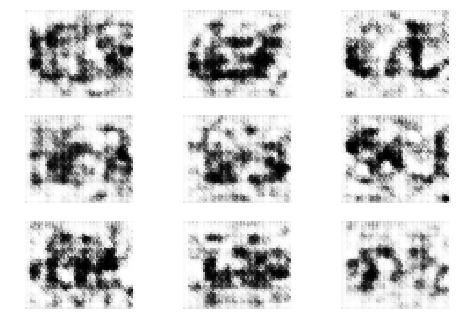

101 [D loss: 1.167319] [G loss: 1.268728]
102 [D loss: 1.479679] [G loss: 1.436724]
103 [D loss: 0.962040] [G loss: 1.448106]
104 [D loss: 1.009797] [G loss: 1.314104]
105 [D loss: 1.213119] [G loss: 1.128339]
106 [D loss: 0.838363] [G loss: 1.244301]
107 [D loss: 0.904918] [G loss: 1.323917]
108 [D loss: 0.974873] [G loss: 1.296486]
109 [D loss: 0.958042] [G loss: 1.376494]
110 [D loss: 1.426392] [G loss: 1.545408]
111 [D loss: 1.037419] [G loss: 2.199153]
112 [D loss: 0.940600] [G loss: 1.658540]
113 [D loss: 1.307129] [G loss: 1.679713]
114 [D loss: 1.081287] [G loss: 1.268739]
115 [D loss: 1.251622] [G loss: 1.767531]
116 [D loss: 0.978132] [G loss: 1.899812]
117 [D loss: 1.120319] [G loss: 1.289402]
118 [D loss: 0.968148] [G loss: 2.035936]
119 [D loss: 1.200244] [G loss: 1.390770]
120 [D loss: 1.068975] [G loss: 1.292105]
121 [D loss: 1.247508] [G loss: 1.035668]
122 [D loss: 1.248786] [G loss: 1.571625]
123 [D loss: 1.016552] [G loss: 1.679649]
124 [D loss: 0.766505] [G loss: 1.

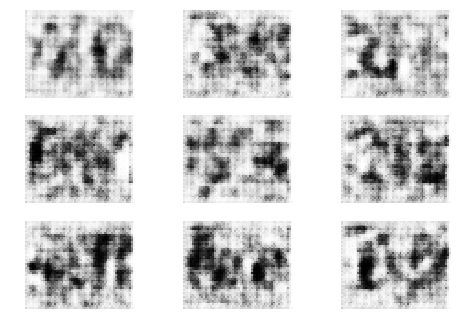

151 [D loss: 0.865757] [G loss: 1.610546]
152 [D loss: 1.057413] [G loss: 1.030680]
153 [D loss: 1.023157] [G loss: 1.498982]
154 [D loss: 0.901768] [G loss: 1.417304]
155 [D loss: 0.956766] [G loss: 1.224010]
156 [D loss: 1.098029] [G loss: 0.966570]
157 [D loss: 1.293024] [G loss: 1.533324]
158 [D loss: 1.063271] [G loss: 1.529428]
159 [D loss: 1.128246] [G loss: 1.298075]
160 [D loss: 1.256962] [G loss: 1.219751]
161 [D loss: 0.871963] [G loss: 1.340846]
162 [D loss: 1.209714] [G loss: 1.357891]
163 [D loss: 1.229634] [G loss: 1.528082]
164 [D loss: 1.121334] [G loss: 1.558930]
165 [D loss: 1.291080] [G loss: 1.364114]
166 [D loss: 0.927318] [G loss: 1.382501]
167 [D loss: 1.373704] [G loss: 1.151578]
168 [D loss: 1.412795] [G loss: 1.396482]
169 [D loss: 1.097851] [G loss: 1.906168]
170 [D loss: 0.868772] [G loss: 1.369972]
171 [D loss: 1.274194] [G loss: 1.653347]
172 [D loss: 1.130809] [G loss: 1.537277]
173 [D loss: 1.077498] [G loss: 1.153085]
174 [D loss: 0.971959] [G loss: 1.

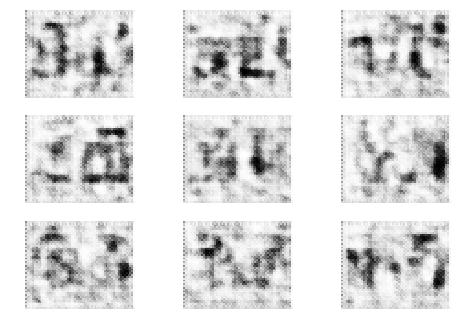

201 [D loss: 1.127041] [G loss: 1.367445]
202 [D loss: 1.222655] [G loss: 1.560789]
203 [D loss: 1.181087] [G loss: 1.313467]
204 [D loss: 1.077455] [G loss: 1.296281]
205 [D loss: 0.882785] [G loss: 1.769267]
206 [D loss: 1.104726] [G loss: 1.366949]
207 [D loss: 1.290321] [G loss: 1.867166]
208 [D loss: 0.812518] [G loss: 1.506438]
209 [D loss: 1.003559] [G loss: 1.211207]
210 [D loss: 1.131949] [G loss: 1.346374]
211 [D loss: 1.243716] [G loss: 1.213246]
212 [D loss: 1.160393] [G loss: 1.192816]
213 [D loss: 0.947798] [G loss: 1.214503]
214 [D loss: 1.128754] [G loss: 1.173316]
215 [D loss: 1.143387] [G loss: 1.164790]
216 [D loss: 0.969512] [G loss: 1.675129]
217 [D loss: 1.072793] [G loss: 1.418216]
218 [D loss: 1.057757] [G loss: 1.542587]
219 [D loss: 1.056120] [G loss: 1.306739]
220 [D loss: 0.901424] [G loss: 1.894527]
221 [D loss: 1.414424] [G loss: 1.210342]
222 [D loss: 0.802063] [G loss: 1.452134]
223 [D loss: 1.052101] [G loss: 1.574276]
224 [D loss: 1.131221] [G loss: 1.

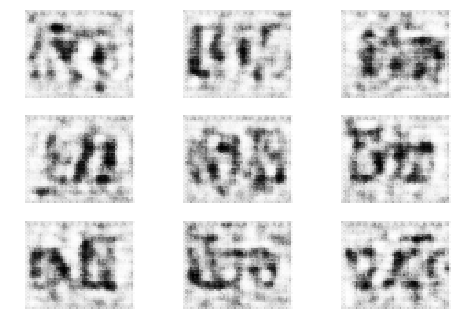

251 [D loss: 1.028079] [G loss: 0.976018]
252 [D loss: 0.907924] [G loss: 1.183394]
253 [D loss: 1.013288] [G loss: 1.408767]
254 [D loss: 0.844576] [G loss: 1.442318]
255 [D loss: 1.185393] [G loss: 1.254426]
256 [D loss: 0.878036] [G loss: 1.430631]
257 [D loss: 1.030772] [G loss: 1.586887]
258 [D loss: 1.144443] [G loss: 1.231881]
259 [D loss: 1.125104] [G loss: 1.479863]
260 [D loss: 1.206670] [G loss: 1.182258]
261 [D loss: 1.116067] [G loss: 1.336218]
262 [D loss: 1.022035] [G loss: 1.160446]
263 [D loss: 1.092106] [G loss: 1.304497]
264 [D loss: 0.929067] [G loss: 1.636797]
265 [D loss: 1.137189] [G loss: 1.053687]
266 [D loss: 1.025651] [G loss: 1.363504]
267 [D loss: 0.909922] [G loss: 1.297526]
268 [D loss: 0.980714] [G loss: 1.246921]
269 [D loss: 1.323906] [G loss: 1.344831]
270 [D loss: 0.773778] [G loss: 1.399873]
271 [D loss: 0.983382] [G loss: 1.418846]
272 [D loss: 1.403407] [G loss: 1.479591]
273 [D loss: 1.255741] [G loss: 1.669621]
274 [D loss: 1.023454] [G loss: 1.

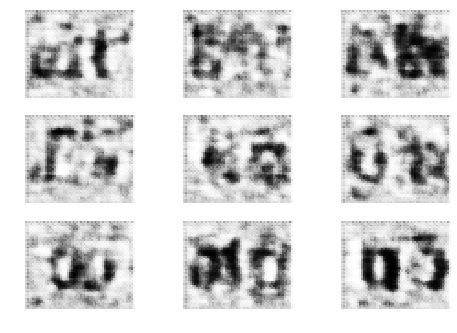

301 [D loss: 1.071811] [G loss: 1.435481]
302 [D loss: 1.079038] [G loss: 1.435208]
303 [D loss: 0.852811] [G loss: 1.429529]
304 [D loss: 1.017029] [G loss: 1.331730]
305 [D loss: 1.171057] [G loss: 1.158884]
306 [D loss: 0.981948] [G loss: 1.270133]
307 [D loss: 0.906707] [G loss: 1.625176]
308 [D loss: 1.115962] [G loss: 1.228827]
309 [D loss: 1.040281] [G loss: 1.265102]
310 [D loss: 1.155996] [G loss: 1.341897]
311 [D loss: 0.961208] [G loss: 1.377771]
312 [D loss: 0.929776] [G loss: 1.215952]
313 [D loss: 1.227024] [G loss: 1.340958]
314 [D loss: 1.305239] [G loss: 1.186749]
315 [D loss: 1.134391] [G loss: 1.864190]
316 [D loss: 0.970221] [G loss: 1.537766]
317 [D loss: 1.044651] [G loss: 1.395804]
318 [D loss: 0.913824] [G loss: 1.180412]
319 [D loss: 1.117325] [G loss: 1.078558]
320 [D loss: 1.065287] [G loss: 1.413657]
321 [D loss: 0.826516] [G loss: 1.327690]
322 [D loss: 0.777075] [G loss: 1.415716]
323 [D loss: 1.112885] [G loss: 1.275274]
324 [D loss: 1.057794] [G loss: 1.

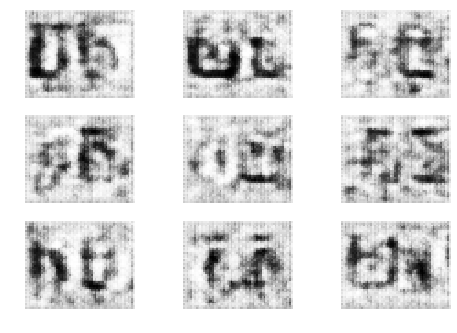

351 [D loss: 0.894925] [G loss: 1.339781]
352 [D loss: 1.024659] [G loss: 1.442462]
353 [D loss: 0.878427] [G loss: 1.512630]
354 [D loss: 1.076735] [G loss: 1.264916]
355 [D loss: 1.255938] [G loss: 1.226323]
356 [D loss: 1.056239] [G loss: 1.353296]
357 [D loss: 0.996612] [G loss: 1.656441]
358 [D loss: 1.109337] [G loss: 1.542847]
359 [D loss: 1.056229] [G loss: 1.270784]
360 [D loss: 1.088062] [G loss: 1.317523]
361 [D loss: 0.960260] [G loss: 1.222103]
362 [D loss: 0.718064] [G loss: 1.398270]
363 [D loss: 0.957886] [G loss: 1.475882]
364 [D loss: 1.168503] [G loss: 1.516515]
365 [D loss: 0.803885] [G loss: 1.769182]
366 [D loss: 0.958236] [G loss: 1.368747]
367 [D loss: 1.177180] [G loss: 1.145584]
368 [D loss: 0.823412] [G loss: 1.064458]
369 [D loss: 0.842003] [G loss: 1.195563]
370 [D loss: 1.056207] [G loss: 1.106732]
371 [D loss: 1.397836] [G loss: 1.051657]
372 [D loss: 0.903854] [G loss: 1.020196]
373 [D loss: 1.034065] [G loss: 1.458105]
374 [D loss: 1.122098] [G loss: 1.

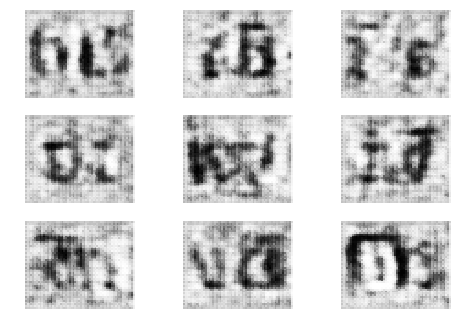

401 [D loss: 1.009298] [G loss: 1.470764]
402 [D loss: 0.891105] [G loss: 1.547591]
403 [D loss: 0.914500] [G loss: 1.431105]
404 [D loss: 0.818911] [G loss: 1.319418]
405 [D loss: 1.204883] [G loss: 1.084232]
406 [D loss: 0.824213] [G loss: 1.411777]
407 [D loss: 1.230430] [G loss: 1.146504]
408 [D loss: 1.002069] [G loss: 1.381306]
409 [D loss: 1.028136] [G loss: 1.320246]
410 [D loss: 0.918662] [G loss: 1.431904]
411 [D loss: 0.968603] [G loss: 1.091615]
412 [D loss: 1.175760] [G loss: 1.060964]
413 [D loss: 0.777693] [G loss: 1.346308]
414 [D loss: 0.794464] [G loss: 1.400854]
415 [D loss: 0.969142] [G loss: 1.457679]
416 [D loss: 0.815208] [G loss: 1.416708]
417 [D loss: 0.992488] [G loss: 1.194354]
418 [D loss: 1.205362] [G loss: 1.706885]
419 [D loss: 1.067017] [G loss: 1.360193]
420 [D loss: 1.021075] [G loss: 1.568759]
421 [D loss: 1.011012] [G loss: 1.440378]
422 [D loss: 1.104861] [G loss: 1.300462]
423 [D loss: 1.202705] [G loss: 1.216770]
424 [D loss: 0.906441] [G loss: 1.

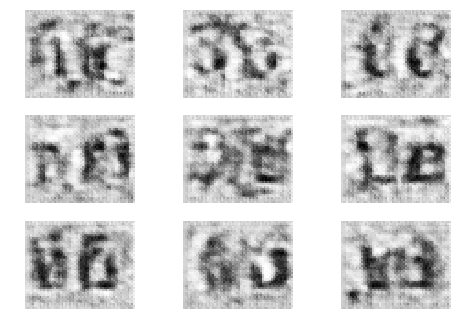

451 [D loss: 0.879379] [G loss: 1.181577]
452 [D loss: 0.638204] [G loss: 1.265293]
453 [D loss: 1.126638] [G loss: 1.198429]
454 [D loss: 0.964539] [G loss: 1.024253]
455 [D loss: 0.998758] [G loss: 1.441111]
456 [D loss: 1.207050] [G loss: 1.325507]
457 [D loss: 0.900478] [G loss: 1.034932]
458 [D loss: 0.856161] [G loss: 1.184296]
459 [D loss: 1.062705] [G loss: 1.524804]
460 [D loss: 1.046064] [G loss: 1.129694]
461 [D loss: 0.798187] [G loss: 1.629148]
462 [D loss: 1.018425] [G loss: 1.273060]
463 [D loss: 1.161383] [G loss: 1.112055]
464 [D loss: 0.804755] [G loss: 0.980641]
465 [D loss: 1.048766] [G loss: 1.272761]
466 [D loss: 0.936180] [G loss: 1.187695]
467 [D loss: 0.669386] [G loss: 1.261147]
468 [D loss: 0.790609] [G loss: 1.418252]
469 [D loss: 0.845630] [G loss: 1.503289]
470 [D loss: 0.889510] [G loss: 1.354313]
471 [D loss: 1.057583] [G loss: 1.114755]
472 [D loss: 0.979411] [G loss: 1.419753]
473 [D loss: 0.748192] [G loss: 1.213732]
474 [D loss: 0.827147] [G loss: 1.

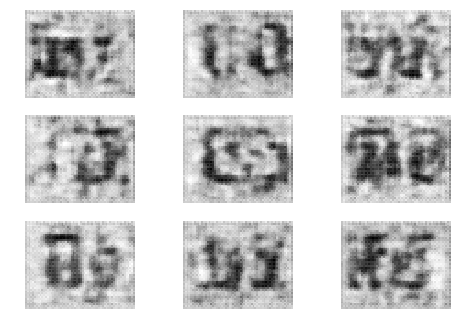

501 [D loss: 0.853300] [G loss: 1.555860]
502 [D loss: 1.021958] [G loss: 1.290840]
503 [D loss: 0.909592] [G loss: 1.291283]
504 [D loss: 0.849457] [G loss: 1.120178]
505 [D loss: 0.851521] [G loss: 1.366979]
506 [D loss: 0.748548] [G loss: 1.244488]
507 [D loss: 0.839821] [G loss: 1.424123]
508 [D loss: 0.986128] [G loss: 0.964240]
509 [D loss: 0.911812] [G loss: 1.347117]
510 [D loss: 1.090625] [G loss: 1.454464]
511 [D loss: 1.161383] [G loss: 1.006124]
512 [D loss: 0.934988] [G loss: 1.769329]
513 [D loss: 1.101230] [G loss: 1.268853]
514 [D loss: 1.049984] [G loss: 1.101958]
515 [D loss: 0.843231] [G loss: 1.017109]
516 [D loss: 1.231788] [G loss: 1.099265]
517 [D loss: 0.930835] [G loss: 0.989954]
518 [D loss: 0.813058] [G loss: 1.201587]
519 [D loss: 1.047051] [G loss: 1.277744]
520 [D loss: 0.896796] [G loss: 1.151051]
521 [D loss: 0.930309] [G loss: 1.035956]
522 [D loss: 0.890434] [G loss: 1.357173]
523 [D loss: 0.966175] [G loss: 1.362382]
524 [D loss: 1.086367] [G loss: 1.

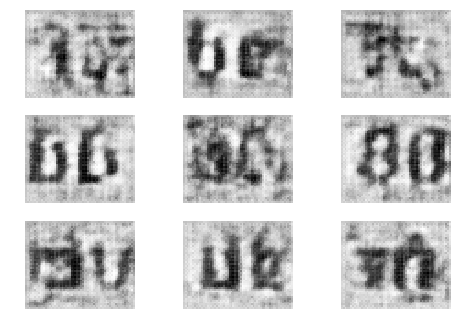

551 [D loss: 1.000439] [G loss: 0.794080]
552 [D loss: 1.026902] [G loss: 1.440390]
553 [D loss: 1.021033] [G loss: 1.213667]
554 [D loss: 0.960313] [G loss: 1.587371]
555 [D loss: 1.099119] [G loss: 1.187444]
556 [D loss: 1.003455] [G loss: 1.344822]
557 [D loss: 0.999262] [G loss: 1.125588]
558 [D loss: 0.992740] [G loss: 1.089680]
559 [D loss: 0.890618] [G loss: 1.143975]
560 [D loss: 0.823788] [G loss: 1.603706]
561 [D loss: 0.916554] [G loss: 1.508199]
562 [D loss: 0.817751] [G loss: 1.430978]
563 [D loss: 0.991948] [G loss: 1.353517]
564 [D loss: 1.121312] [G loss: 0.956784]
565 [D loss: 1.185129] [G loss: 1.190103]
566 [D loss: 0.752053] [G loss: 1.220897]
567 [D loss: 0.952328] [G loss: 1.298284]
568 [D loss: 0.906207] [G loss: 0.922957]
569 [D loss: 0.870076] [G loss: 1.376457]
570 [D loss: 1.041451] [G loss: 1.123260]
571 [D loss: 0.960002] [G loss: 1.173081]
572 [D loss: 0.606036] [G loss: 1.031400]
573 [D loss: 0.727566] [G loss: 1.037092]
574 [D loss: 1.101845] [G loss: 1.

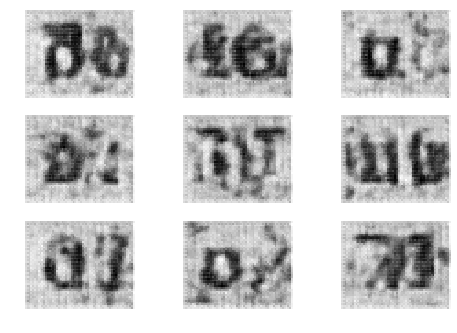

601 [D loss: 1.135964] [G loss: 1.202080]
602 [D loss: 1.072382] [G loss: 1.146481]
603 [D loss: 0.973406] [G loss: 1.409445]
604 [D loss: 0.800388] [G loss: 1.335395]
605 [D loss: 0.665981] [G loss: 1.412331]
606 [D loss: 1.051800] [G loss: 1.459116]
607 [D loss: 0.736296] [G loss: 1.327937]
608 [D loss: 0.734094] [G loss: 1.345861]
609 [D loss: 1.170848] [G loss: 0.862399]
610 [D loss: 0.969036] [G loss: 1.095551]
611 [D loss: 0.689623] [G loss: 1.339358]
612 [D loss: 0.983679] [G loss: 1.262540]
613 [D loss: 0.900385] [G loss: 1.388974]
614 [D loss: 0.913939] [G loss: 1.278671]
615 [D loss: 1.017480] [G loss: 1.214307]
616 [D loss: 0.900108] [G loss: 1.154072]
617 [D loss: 1.110735] [G loss: 1.283087]
618 [D loss: 0.816862] [G loss: 1.517032]
619 [D loss: 0.837974] [G loss: 1.314289]
620 [D loss: 0.845193] [G loss: 1.023503]
621 [D loss: 0.940802] [G loss: 1.099355]
622 [D loss: 0.997257] [G loss: 1.097594]
623 [D loss: 1.082944] [G loss: 0.751821]
624 [D loss: 0.970906] [G loss: 0.

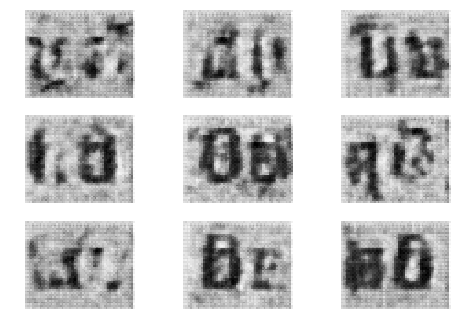

651 [D loss: 0.928061] [G loss: 1.339245]
652 [D loss: 0.913330] [G loss: 1.257075]
653 [D loss: 0.824623] [G loss: 1.180810]
654 [D loss: 0.959111] [G loss: 0.947898]
655 [D loss: 0.983125] [G loss: 1.077993]
656 [D loss: 0.914046] [G loss: 0.878602]
657 [D loss: 0.909792] [G loss: 1.032521]
658 [D loss: 1.067229] [G loss: 1.161140]
659 [D loss: 0.952587] [G loss: 1.096626]
660 [D loss: 0.884714] [G loss: 1.394320]
661 [D loss: 0.870814] [G loss: 1.361518]
662 [D loss: 0.961772] [G loss: 1.516576]
663 [D loss: 1.075089] [G loss: 1.343976]
664 [D loss: 0.932445] [G loss: 1.067535]
665 [D loss: 0.895451] [G loss: 1.116945]
666 [D loss: 1.033380] [G loss: 1.169329]
667 [D loss: 0.870952] [G loss: 1.489675]
668 [D loss: 0.993953] [G loss: 1.526040]
669 [D loss: 0.827349] [G loss: 1.090238]
670 [D loss: 0.863064] [G loss: 1.131816]
671 [D loss: 0.884423] [G loss: 1.289538]
672 [D loss: 0.912380] [G loss: 1.454047]
673 [D loss: 0.633777] [G loss: 1.100030]
674 [D loss: 0.804125] [G loss: 1.

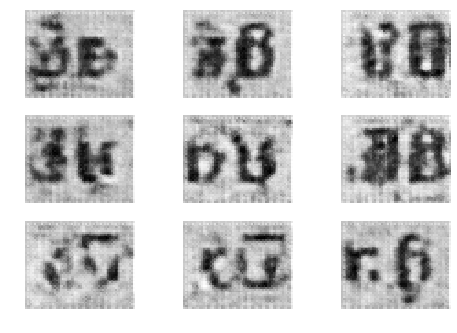

701 [D loss: 1.148421] [G loss: 1.345162]
702 [D loss: 0.727215] [G loss: 1.353144]
703 [D loss: 0.807441] [G loss: 1.331623]
704 [D loss: 0.884972] [G loss: 0.913225]
705 [D loss: 1.005039] [G loss: 0.908975]
706 [D loss: 0.850668] [G loss: 0.933986]
707 [D loss: 0.677757] [G loss: 1.272120]
708 [D loss: 1.061110] [G loss: 1.238352]
709 [D loss: 0.783329] [G loss: 0.987557]
710 [D loss: 0.815413] [G loss: 1.003060]
711 [D loss: 1.054051] [G loss: 0.950291]
712 [D loss: 0.851876] [G loss: 1.237709]
713 [D loss: 1.101429] [G loss: 1.412408]
714 [D loss: 1.076684] [G loss: 1.263023]
715 [D loss: 0.854337] [G loss: 1.292225]
716 [D loss: 0.890050] [G loss: 1.336514]
717 [D loss: 0.947553] [G loss: 1.439715]
718 [D loss: 0.869491] [G loss: 1.110272]
719 [D loss: 0.814939] [G loss: 1.009643]
720 [D loss: 0.842770] [G loss: 0.908989]
721 [D loss: 1.028029] [G loss: 0.922432]
722 [D loss: 0.956689] [G loss: 1.202556]
723 [D loss: 0.893165] [G loss: 1.249970]
724 [D loss: 1.026032] [G loss: 1.

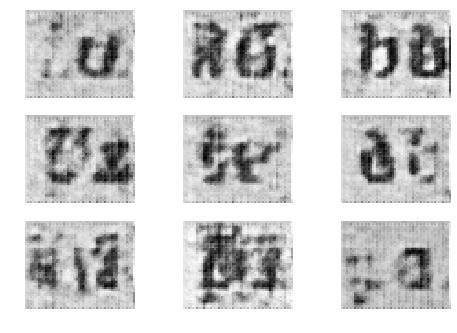

751 [D loss: 0.712068] [G loss: 1.495086]
752 [D loss: 0.867035] [G loss: 1.247011]
753 [D loss: 0.931540] [G loss: 1.257732]
754 [D loss: 0.972400] [G loss: 0.934012]
755 [D loss: 0.921447] [G loss: 1.217043]
756 [D loss: 0.937926] [G loss: 0.991200]
757 [D loss: 0.920043] [G loss: 1.314132]
758 [D loss: 0.797295] [G loss: 1.246659]
759 [D loss: 0.909170] [G loss: 0.955125]
760 [D loss: 0.993239] [G loss: 1.136707]
761 [D loss: 0.771928] [G loss: 1.116131]
762 [D loss: 0.959644] [G loss: 0.967851]
763 [D loss: 0.804529] [G loss: 0.904774]
764 [D loss: 1.051667] [G loss: 1.377811]
765 [D loss: 0.843411] [G loss: 1.189488]
766 [D loss: 0.857571] [G loss: 1.043953]
767 [D loss: 0.895080] [G loss: 1.633514]
768 [D loss: 0.912609] [G loss: 1.197190]
769 [D loss: 0.884368] [G loss: 1.082249]
770 [D loss: 0.981681] [G loss: 1.032976]
771 [D loss: 0.843835] [G loss: 1.125790]
772 [D loss: 0.780849] [G loss: 1.240541]
773 [D loss: 0.787963] [G loss: 1.147993]
774 [D loss: 0.951775] [G loss: 0.

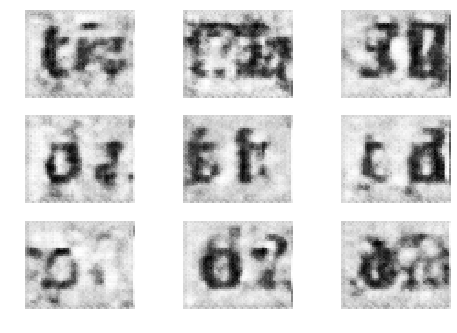

801 [D loss: 0.895968] [G loss: 0.951482]
802 [D loss: 0.826899] [G loss: 1.120670]
803 [D loss: 0.937517] [G loss: 0.915631]
804 [D loss: 0.997383] [G loss: 1.206391]
805 [D loss: 0.956614] [G loss: 1.248393]
806 [D loss: 0.966913] [G loss: 1.162660]
807 [D loss: 0.844681] [G loss: 1.340817]
808 [D loss: 0.984006] [G loss: 1.460238]
809 [D loss: 1.040392] [G loss: 1.145321]
810 [D loss: 0.905042] [G loss: 1.300147]
811 [D loss: 0.869417] [G loss: 1.334510]
812 [D loss: 0.785717] [G loss: 1.584856]
813 [D loss: 0.838826] [G loss: 1.349979]
814 [D loss: 0.919842] [G loss: 1.286289]
815 [D loss: 0.819206] [G loss: 1.225145]
816 [D loss: 0.744219] [G loss: 1.273426]
817 [D loss: 1.037249] [G loss: 1.052597]
818 [D loss: 0.829704] [G loss: 1.020796]
819 [D loss: 0.926182] [G loss: 1.196347]
820 [D loss: 0.839325] [G loss: 1.317351]
821 [D loss: 0.792936] [G loss: 1.087142]
822 [D loss: 0.982805] [G loss: 0.997121]
823 [D loss: 0.851597] [G loss: 0.972068]
824 [D loss: 0.766870] [G loss: 1.

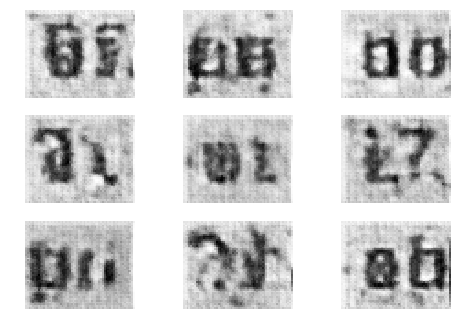

851 [D loss: 0.836193] [G loss: 0.921534]
852 [D loss: 0.769083] [G loss: 1.372710]
853 [D loss: 1.076503] [G loss: 1.226229]
854 [D loss: 0.950567] [G loss: 1.125173]
855 [D loss: 0.864245] [G loss: 1.333525]
856 [D loss: 0.838770] [G loss: 1.121474]
857 [D loss: 1.020285] [G loss: 1.488372]
858 [D loss: 0.995136] [G loss: 0.826489]
859 [D loss: 0.997979] [G loss: 1.167323]
860 [D loss: 0.756328] [G loss: 1.596958]
861 [D loss: 0.987037] [G loss: 1.425815]
862 [D loss: 0.856572] [G loss: 1.191732]
863 [D loss: 0.910364] [G loss: 1.493986]
864 [D loss: 0.949570] [G loss: 1.320018]
865 [D loss: 0.766251] [G loss: 1.218359]
866 [D loss: 0.899705] [G loss: 0.900486]
867 [D loss: 0.971439] [G loss: 1.222736]
868 [D loss: 0.767872] [G loss: 1.246989]
869 [D loss: 0.930389] [G loss: 1.297921]
870 [D loss: 0.846183] [G loss: 1.240188]
871 [D loss: 0.911814] [G loss: 1.427468]
872 [D loss: 0.681007] [G loss: 1.022637]
873 [D loss: 0.872780] [G loss: 0.903045]
874 [D loss: 0.711667] [G loss: 1.

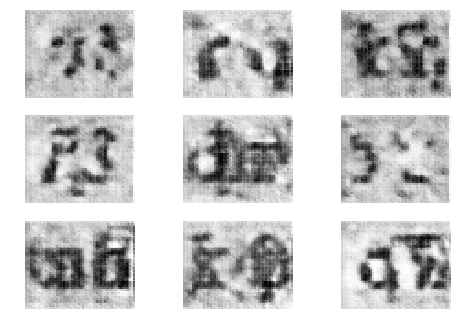

901 [D loss: 0.884779] [G loss: 0.829357]
902 [D loss: 0.865631] [G loss: 1.130465]
903 [D loss: 0.986021] [G loss: 1.142189]
904 [D loss: 0.783250] [G loss: 1.153651]
905 [D loss: 0.716369] [G loss: 1.366047]
906 [D loss: 0.826793] [G loss: 1.263984]
907 [D loss: 0.785995] [G loss: 1.273051]
908 [D loss: 0.886062] [G loss: 1.220314]
909 [D loss: 1.045849] [G loss: 0.847038]
910 [D loss: 0.865852] [G loss: 1.207326]
911 [D loss: 0.925034] [G loss: 1.098467]
912 [D loss: 0.798614] [G loss: 1.252690]
913 [D loss: 0.959702] [G loss: 1.044911]
914 [D loss: 0.763307] [G loss: 1.304436]
915 [D loss: 0.827340] [G loss: 1.274607]
916 [D loss: 0.933262] [G loss: 0.873871]
917 [D loss: 0.827750] [G loss: 1.218864]
918 [D loss: 0.898667] [G loss: 1.162050]
919 [D loss: 0.973730] [G loss: 1.414438]
920 [D loss: 0.921262] [G loss: 1.542708]
921 [D loss: 0.864695] [G loss: 0.839858]
922 [D loss: 0.930534] [G loss: 1.246066]
923 [D loss: 0.966249] [G loss: 1.220079]
924 [D loss: 0.741048] [G loss: 1.

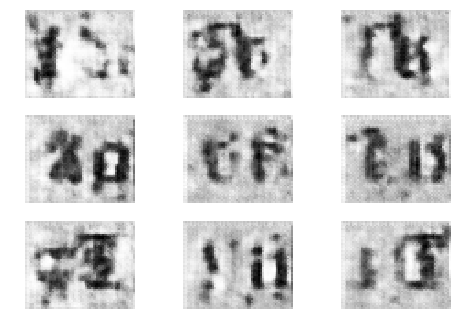

951 [D loss: 0.985715] [G loss: 1.178043]
952 [D loss: 0.762618] [G loss: 1.329691]
953 [D loss: 0.738401] [G loss: 1.023241]
954 [D loss: 0.888623] [G loss: 1.222553]
955 [D loss: 0.974579] [G loss: 1.141379]
956 [D loss: 0.947160] [G loss: 1.252389]
957 [D loss: 0.817973] [G loss: 0.974453]
958 [D loss: 0.885484] [G loss: 0.837787]
959 [D loss: 0.894595] [G loss: 1.150521]
960 [D loss: 0.889367] [G loss: 1.196932]
961 [D loss: 0.815717] [G loss: 1.344574]
962 [D loss: 0.791368] [G loss: 1.126386]
963 [D loss: 0.863515] [G loss: 0.955724]
964 [D loss: 0.779945] [G loss: 0.978060]
965 [D loss: 0.845745] [G loss: 1.299070]
966 [D loss: 0.734888] [G loss: 1.077772]
967 [D loss: 0.960963] [G loss: 1.265553]
968 [D loss: 0.789043] [G loss: 1.423324]
969 [D loss: 0.827545] [G loss: 1.230914]
970 [D loss: 0.880428] [G loss: 1.016921]
971 [D loss: 0.875886] [G loss: 1.067203]
972 [D loss: 0.834906] [G loss: 1.317569]
973 [D loss: 0.976198] [G loss: 1.005752]
974 [D loss: 1.042596] [G loss: 1.

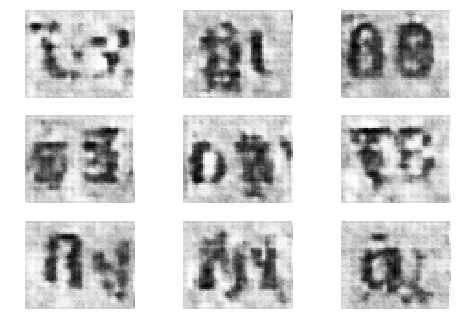

1001 [D loss: 0.816274] [G loss: 1.160058]
1002 [D loss: 0.729827] [G loss: 1.324106]
1003 [D loss: 0.844276] [G loss: 0.986020]
1004 [D loss: 0.748827] [G loss: 1.255894]
1005 [D loss: 0.932131] [G loss: 1.316323]
1006 [D loss: 0.683535] [G loss: 1.129854]
1007 [D loss: 0.966132] [G loss: 1.279842]
1008 [D loss: 0.826263] [G loss: 1.093377]
1009 [D loss: 0.791181] [G loss: 1.182766]
1010 [D loss: 0.833478] [G loss: 1.426024]
1011 [D loss: 0.924825] [G loss: 1.383492]
1012 [D loss: 0.734405] [G loss: 1.192631]
1013 [D loss: 0.862873] [G loss: 1.146922]
1014 [D loss: 0.863007] [G loss: 1.168461]
1015 [D loss: 0.651364] [G loss: 1.501399]
1016 [D loss: 0.851795] [G loss: 1.169235]
1017 [D loss: 0.875240] [G loss: 0.995344]
1018 [D loss: 0.815245] [G loss: 1.204300]
1019 [D loss: 0.724101] [G loss: 1.285028]
1020 [D loss: 0.850974] [G loss: 1.478735]
1021 [D loss: 0.772461] [G loss: 1.506203]
1022 [D loss: 0.770524] [G loss: 1.025638]
1023 [D loss: 1.031270] [G loss: 0.935173]
1024 [D los

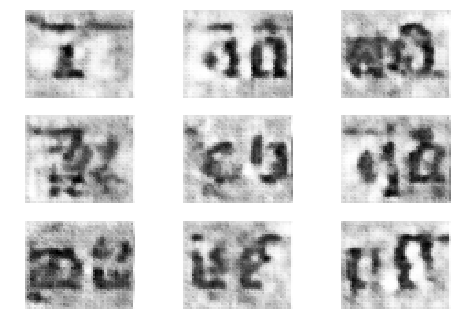

1051 [D loss: 0.779447] [G loss: 1.413269]
1052 [D loss: 0.868963] [G loss: 1.322986]
1053 [D loss: 0.875947] [G loss: 1.031701]
1054 [D loss: 0.734248] [G loss: 1.033619]
1055 [D loss: 0.832076] [G loss: 1.238285]
1056 [D loss: 0.741813] [G loss: 1.169880]
1057 [D loss: 0.759857] [G loss: 0.986300]
1058 [D loss: 0.857420] [G loss: 0.986963]
1059 [D loss: 0.707892] [G loss: 1.187880]
1060 [D loss: 0.857274] [G loss: 1.108543]
1061 [D loss: 0.767643] [G loss: 1.054695]
1062 [D loss: 0.858705] [G loss: 0.872531]
1063 [D loss: 0.725229] [G loss: 1.210152]
1064 [D loss: 0.916463] [G loss: 0.946009]
1065 [D loss: 0.954852] [G loss: 1.092041]
1066 [D loss: 0.691312] [G loss: 1.173540]
1067 [D loss: 0.830421] [G loss: 1.272062]
1068 [D loss: 0.816346] [G loss: 0.799933]
1069 [D loss: 0.871871] [G loss: 1.091396]
1070 [D loss: 0.961779] [G loss: 1.091507]
1071 [D loss: 0.841577] [G loss: 1.094914]
1072 [D loss: 0.820087] [G loss: 1.290307]
1073 [D loss: 0.853990] [G loss: 0.960996]
1074 [D los

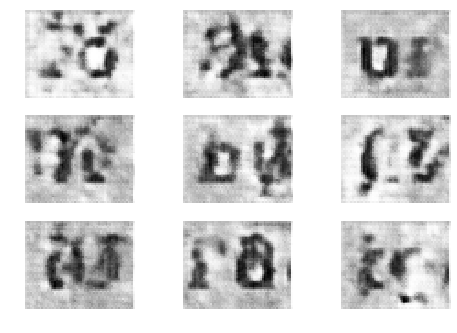

1101 [D loss: 0.878044] [G loss: 1.064953]
1102 [D loss: 1.023621] [G loss: 1.068180]
1103 [D loss: 0.762949] [G loss: 1.170551]
1104 [D loss: 0.835179] [G loss: 1.475064]
1105 [D loss: 0.989866] [G loss: 1.172979]
1106 [D loss: 0.858592] [G loss: 1.187434]
1107 [D loss: 0.816989] [G loss: 0.986005]
1108 [D loss: 0.803881] [G loss: 1.099425]
1109 [D loss: 0.896618] [G loss: 1.535438]
1110 [D loss: 0.921468] [G loss: 1.471611]
1111 [D loss: 0.997357] [G loss: 1.302501]
1112 [D loss: 0.656483] [G loss: 1.115380]
1113 [D loss: 0.910665] [G loss: 1.157333]
1114 [D loss: 0.772436] [G loss: 1.049660]
1115 [D loss: 0.976264] [G loss: 1.169803]
1116 [D loss: 0.727471] [G loss: 1.109231]
1117 [D loss: 0.809061] [G loss: 1.193921]
1118 [D loss: 0.802269] [G loss: 0.990042]
1119 [D loss: 0.856140] [G loss: 0.991206]
1120 [D loss: 0.854966] [G loss: 1.119186]
1121 [D loss: 0.853295] [G loss: 1.291184]
1122 [D loss: 0.730565] [G loss: 1.572785]
1123 [D loss: 0.831564] [G loss: 1.233831]
1124 [D los

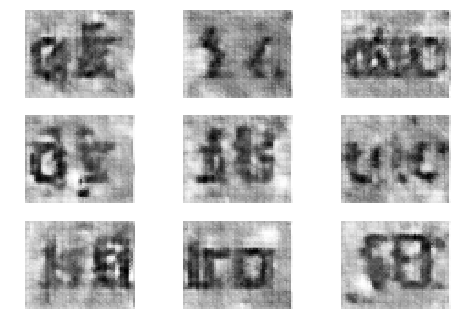

1151 [D loss: 0.866488] [G loss: 0.947462]
1152 [D loss: 0.865764] [G loss: 1.182703]
1153 [D loss: 0.780797] [G loss: 1.197541]
1154 [D loss: 0.762156] [G loss: 1.265332]
1155 [D loss: 0.795099] [G loss: 0.944975]
1156 [D loss: 0.907892] [G loss: 1.099536]
1157 [D loss: 0.809460] [G loss: 1.337103]
1158 [D loss: 0.773597] [G loss: 1.455781]
1159 [D loss: 0.950471] [G loss: 1.164761]
1160 [D loss: 0.634298] [G loss: 1.590369]
1161 [D loss: 0.659529] [G loss: 1.117604]
1162 [D loss: 0.810961] [G loss: 1.135401]
1163 [D loss: 0.759454] [G loss: 1.240575]
1164 [D loss: 0.863449] [G loss: 0.963876]
1165 [D loss: 0.802458] [G loss: 1.082875]
1166 [D loss: 0.830273] [G loss: 1.237736]
1167 [D loss: 0.824865] [G loss: 1.011297]
1168 [D loss: 0.794130] [G loss: 1.068544]
1169 [D loss: 0.916414] [G loss: 1.071312]
1170 [D loss: 0.902986] [G loss: 0.990115]
1171 [D loss: 0.753179] [G loss: 1.072901]
1172 [D loss: 0.722488] [G loss: 1.268235]
1173 [D loss: 0.880027] [G loss: 1.280628]
1174 [D los

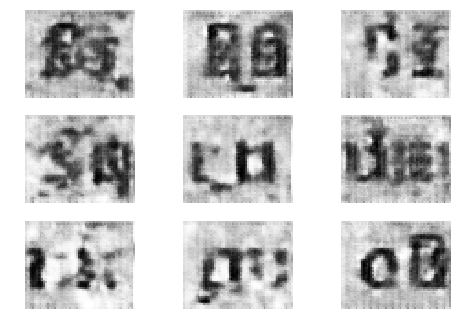

1201 [D loss: 0.827126] [G loss: 1.235365]
1202 [D loss: 0.821342] [G loss: 1.135064]
1203 [D loss: 0.928906] [G loss: 1.134143]
1204 [D loss: 0.746808] [G loss: 1.247815]
1205 [D loss: 0.816600] [G loss: 1.214472]
1206 [D loss: 0.863504] [G loss: 0.942436]
1207 [D loss: 0.959611] [G loss: 0.980061]
1208 [D loss: 0.877561] [G loss: 0.954026]
1209 [D loss: 0.897915] [G loss: 1.047900]
1210 [D loss: 0.742267] [G loss: 1.174179]
1211 [D loss: 0.814693] [G loss: 1.155808]
1212 [D loss: 0.706356] [G loss: 1.047166]
1213 [D loss: 0.739737] [G loss: 1.107522]
1214 [D loss: 0.966442] [G loss: 1.263563]
1215 [D loss: 0.801083] [G loss: 1.116986]
1216 [D loss: 0.849026] [G loss: 1.136370]
1217 [D loss: 0.905853] [G loss: 1.156378]
1218 [D loss: 0.937071] [G loss: 1.303733]
1219 [D loss: 0.917316] [G loss: 1.205018]
1220 [D loss: 0.896615] [G loss: 1.135764]
1221 [D loss: 0.894164] [G loss: 1.164267]
1222 [D loss: 0.955025] [G loss: 0.877431]
1223 [D loss: 0.778829] [G loss: 1.238307]
1224 [D los

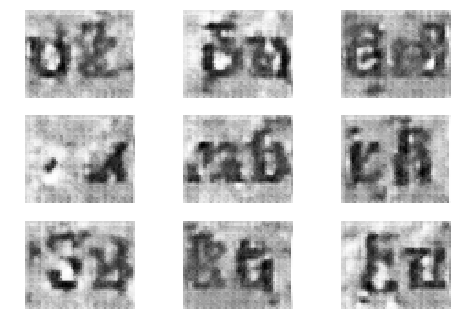

1251 [D loss: 0.707939] [G loss: 1.298122]
1252 [D loss: 0.674762] [G loss: 1.221502]
1253 [D loss: 0.864459] [G loss: 1.332549]
1254 [D loss: 0.991466] [G loss: 1.117733]
1255 [D loss: 0.695900] [G loss: 1.002664]
1256 [D loss: 0.918264] [G loss: 1.078320]
1257 [D loss: 0.604772] [G loss: 1.460971]
1258 [D loss: 0.955593] [G loss: 1.174469]
1259 [D loss: 0.680356] [G loss: 1.034460]
1260 [D loss: 0.876356] [G loss: 0.976992]
1261 [D loss: 0.759102] [G loss: 0.979797]
1262 [D loss: 0.875446] [G loss: 1.127408]
1263 [D loss: 0.704241] [G loss: 1.593579]
1264 [D loss: 0.842600] [G loss: 1.354393]
1265 [D loss: 0.713761] [G loss: 0.962386]
1266 [D loss: 0.958952] [G loss: 0.937445]
1267 [D loss: 0.854310] [G loss: 1.211745]
1268 [D loss: 0.764607] [G loss: 1.050950]
1269 [D loss: 1.127403] [G loss: 1.177560]
1270 [D loss: 0.866669] [G loss: 0.999892]
1271 [D loss: 0.941491] [G loss: 1.023153]
1272 [D loss: 0.909077] [G loss: 0.953410]
1273 [D loss: 0.851818] [G loss: 1.257711]
1274 [D los

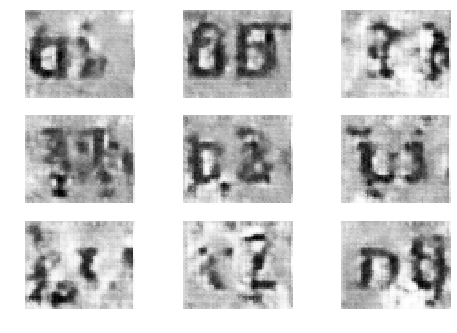

1301 [D loss: 0.789286] [G loss: 0.928544]
1302 [D loss: 0.687798] [G loss: 1.139523]
1303 [D loss: 0.601034] [G loss: 1.092868]
1304 [D loss: 0.894477] [G loss: 1.231297]
1305 [D loss: 0.727275] [G loss: 1.261097]
1306 [D loss: 0.922612] [G loss: 1.158822]
1307 [D loss: 0.895846] [G loss: 0.936730]
1308 [D loss: 0.782664] [G loss: 1.122350]
1309 [D loss: 0.653056] [G loss: 1.273676]
1310 [D loss: 0.802566] [G loss: 1.253896]
1311 [D loss: 0.923382] [G loss: 1.031605]
1312 [D loss: 0.824959] [G loss: 1.029193]
1313 [D loss: 0.630268] [G loss: 1.357127]
1314 [D loss: 0.828521] [G loss: 1.427145]
1315 [D loss: 0.906310] [G loss: 1.070992]
1316 [D loss: 0.924047] [G loss: 1.085726]
1317 [D loss: 0.709588] [G loss: 1.157434]
1318 [D loss: 0.632570] [G loss: 1.196621]
1319 [D loss: 0.621658] [G loss: 1.292247]
1320 [D loss: 0.645267] [G loss: 1.000326]
1321 [D loss: 0.767364] [G loss: 1.148360]
1322 [D loss: 0.675712] [G loss: 1.171896]
1323 [D loss: 0.867596] [G loss: 1.071028]
1324 [D los

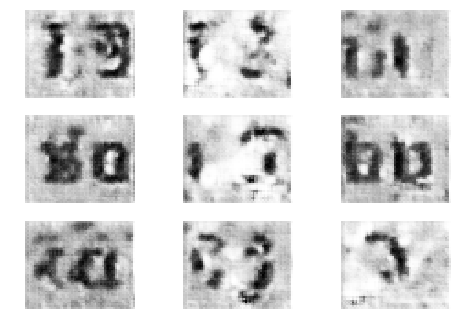

1351 [D loss: 0.711651] [G loss: 1.532690]
1352 [D loss: 0.791217] [G loss: 1.327143]
1353 [D loss: 0.798577] [G loss: 1.061264]
1354 [D loss: 0.768105] [G loss: 1.346524]
1355 [D loss: 0.970480] [G loss: 0.942087]
1356 [D loss: 0.769315] [G loss: 1.275557]
1357 [D loss: 0.860592] [G loss: 1.048745]
1358 [D loss: 0.663984] [G loss: 1.126586]
1359 [D loss: 0.856613] [G loss: 1.221434]
1360 [D loss: 0.745173] [G loss: 1.242790]
1361 [D loss: 0.914648] [G loss: 1.363003]
1362 [D loss: 0.689062] [G loss: 1.159861]
1363 [D loss: 0.826832] [G loss: 1.194928]
1364 [D loss: 0.653309] [G loss: 1.219842]
1365 [D loss: 0.908878] [G loss: 1.018821]
1366 [D loss: 0.859253] [G loss: 1.010741]
1367 [D loss: 0.731538] [G loss: 1.085218]
1368 [D loss: 0.899887] [G loss: 1.234791]
1369 [D loss: 0.830359] [G loss: 1.297124]
1370 [D loss: 0.981131] [G loss: 1.432704]
1371 [D loss: 0.549059] [G loss: 1.682190]
1372 [D loss: 0.796930] [G loss: 1.329040]
1373 [D loss: 0.794492] [G loss: 1.250566]
1374 [D los

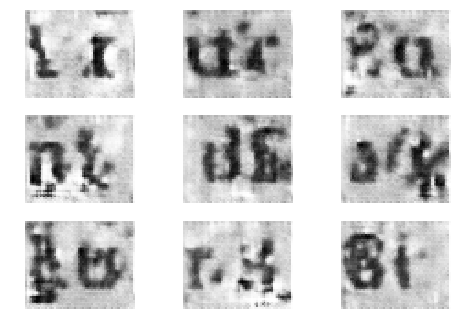

1401 [D loss: 0.701391] [G loss: 1.172041]
1402 [D loss: 0.920039] [G loss: 1.119554]
1403 [D loss: 0.762895] [G loss: 1.254322]
1404 [D loss: 0.670589] [G loss: 1.278403]
1405 [D loss: 0.948905] [G loss: 1.066154]
1406 [D loss: 0.849562] [G loss: 0.660987]
1407 [D loss: 0.683430] [G loss: 1.051284]
1408 [D loss: 0.702210] [G loss: 1.463246]
1409 [D loss: 0.673342] [G loss: 1.047413]
1410 [D loss: 0.812559] [G loss: 1.057834]
1411 [D loss: 0.718914] [G loss: 1.284902]
1412 [D loss: 0.627234] [G loss: 1.182040]
1413 [D loss: 0.695003] [G loss: 1.370163]
1414 [D loss: 0.809930] [G loss: 1.318969]
1415 [D loss: 0.737295] [G loss: 1.518573]
1416 [D loss: 1.029200] [G loss: 1.138401]
1417 [D loss: 0.868154] [G loss: 0.949880]
1418 [D loss: 0.928738] [G loss: 0.964796]
1419 [D loss: 0.903513] [G loss: 0.952962]
1420 [D loss: 0.912597] [G loss: 0.917139]
1421 [D loss: 0.765539] [G loss: 1.251956]
1422 [D loss: 0.714628] [G loss: 1.514880]
1423 [D loss: 0.935280] [G loss: 1.287082]
1424 [D los

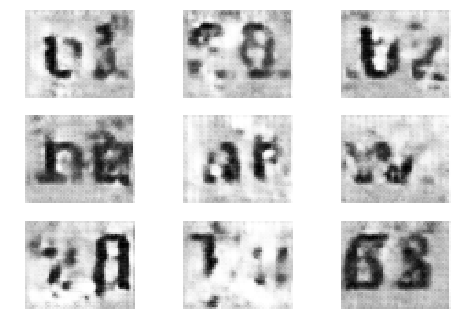

1451 [D loss: 0.637164] [G loss: 1.192974]
1452 [D loss: 0.980837] [G loss: 1.105184]
1453 [D loss: 0.579968] [G loss: 1.081671]
1454 [D loss: 0.794978] [G loss: 0.940771]
1455 [D loss: 0.840940] [G loss: 1.255756]
1456 [D loss: 0.599597] [G loss: 1.506705]
1457 [D loss: 0.636552] [G loss: 1.369898]
1458 [D loss: 0.740139] [G loss: 1.393821]
1459 [D loss: 0.714850] [G loss: 1.213139]
1460 [D loss: 0.643503] [G loss: 1.318503]
1461 [D loss: 0.636763] [G loss: 1.230465]
1462 [D loss: 1.024915] [G loss: 0.929496]
1463 [D loss: 0.562569] [G loss: 1.382121]
1464 [D loss: 0.987910] [G loss: 1.124586]
1465 [D loss: 0.936258] [G loss: 1.060147]
1466 [D loss: 0.652231] [G loss: 1.129155]
1467 [D loss: 0.722424] [G loss: 1.353128]
1468 [D loss: 0.794417] [G loss: 1.452721]
1469 [D loss: 0.793898] [G loss: 1.112280]
1470 [D loss: 0.700508] [G loss: 1.245492]
1471 [D loss: 0.794655] [G loss: 1.272140]
1472 [D loss: 0.672324] [G loss: 1.282005]
1473 [D loss: 0.873724] [G loss: 1.224015]
1474 [D los

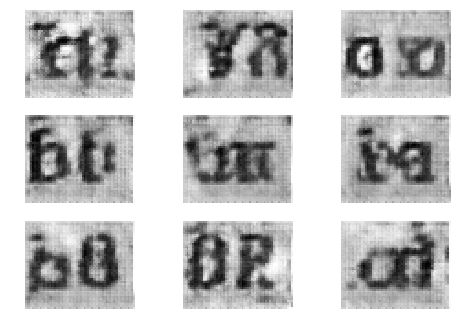

1501 [D loss: 0.745551] [G loss: 1.263523]
1502 [D loss: 0.937815] [G loss: 1.358877]
1503 [D loss: 0.797618] [G loss: 1.542169]
1504 [D loss: 0.780795] [G loss: 1.624499]
1505 [D loss: 0.882696] [G loss: 1.109094]
1506 [D loss: 0.753549] [G loss: 1.030735]
1507 [D loss: 0.737773] [G loss: 0.918543]
1508 [D loss: 0.686369] [G loss: 1.280714]
1509 [D loss: 0.802465] [G loss: 1.291561]
1510 [D loss: 0.742543] [G loss: 1.325208]
1511 [D loss: 0.895773] [G loss: 1.119420]
1512 [D loss: 0.720146] [G loss: 1.280791]
1513 [D loss: 0.745279] [G loss: 1.227431]
1514 [D loss: 0.763575] [G loss: 1.298098]
1515 [D loss: 0.738076] [G loss: 1.422611]
1516 [D loss: 0.708204] [G loss: 1.447468]
1517 [D loss: 0.582999] [G loss: 1.330065]
1518 [D loss: 0.832354] [G loss: 1.220188]
1519 [D loss: 0.756705] [G loss: 1.417344]
1520 [D loss: 0.815486] [G loss: 0.895178]
1521 [D loss: 0.669333] [G loss: 1.348972]
1522 [D loss: 0.603704] [G loss: 1.189987]
1523 [D loss: 0.684007] [G loss: 1.168176]
1524 [D los

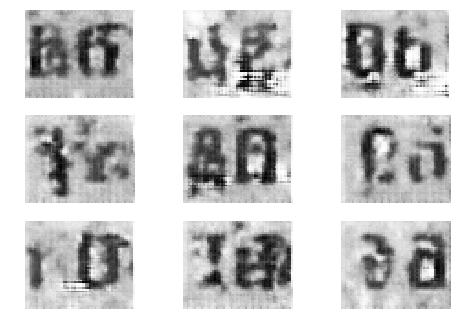

1551 [D loss: 0.814518] [G loss: 1.259419]
1552 [D loss: 0.890670] [G loss: 1.122369]
1553 [D loss: 0.803142] [G loss: 1.286484]
1554 [D loss: 0.814790] [G loss: 0.945761]
1555 [D loss: 0.761654] [G loss: 1.258665]
1556 [D loss: 0.734718] [G loss: 1.160806]
1557 [D loss: 0.896493] [G loss: 1.352761]
1558 [D loss: 0.706022] [G loss: 1.086763]
1559 [D loss: 0.693455] [G loss: 1.057425]
1560 [D loss: 0.719349] [G loss: 1.261190]
1561 [D loss: 0.637306] [G loss: 1.444931]
1562 [D loss: 0.771457] [G loss: 1.114903]
1563 [D loss: 0.970414] [G loss: 1.067384]
1564 [D loss: 0.946034] [G loss: 1.080674]
1565 [D loss: 0.781625] [G loss: 1.170583]
1566 [D loss: 0.783215] [G loss: 1.355474]
1567 [D loss: 0.798501] [G loss: 1.324445]
1568 [D loss: 0.785685] [G loss: 1.263949]
1569 [D loss: 0.886047] [G loss: 1.058995]
1570 [D loss: 0.718203] [G loss: 1.084178]
1571 [D loss: 0.782961] [G loss: 1.109938]
1572 [D loss: 0.756953] [G loss: 0.976040]
1573 [D loss: 0.788594] [G loss: 0.967568]
1574 [D los

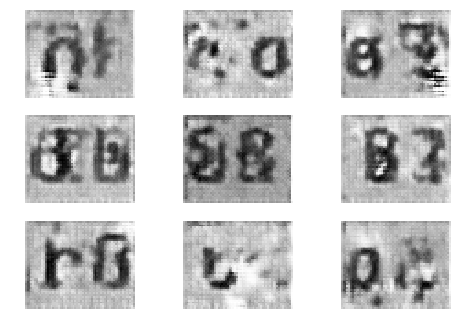

1601 [D loss: 0.900402] [G loss: 1.108168]
1602 [D loss: 0.738945] [G loss: 1.139711]
1603 [D loss: 0.852047] [G loss: 1.128650]
1604 [D loss: 0.918694] [G loss: 1.107483]
1605 [D loss: 0.780563] [G loss: 1.052959]
1606 [D loss: 0.738300] [G loss: 1.149470]
1607 [D loss: 0.975343] [G loss: 0.852591]
1608 [D loss: 0.638052] [G loss: 1.202498]
1609 [D loss: 0.904767] [G loss: 1.041512]
1610 [D loss: 0.681853] [G loss: 1.158489]
1611 [D loss: 0.627208] [G loss: 1.385513]
1612 [D loss: 0.721495] [G loss: 1.152644]
1613 [D loss: 0.797711] [G loss: 1.166616]
1614 [D loss: 0.625967] [G loss: 1.109765]
1615 [D loss: 0.712134] [G loss: 0.985880]
1616 [D loss: 0.691950] [G loss: 1.086405]
1617 [D loss: 0.752843] [G loss: 1.159513]
1618 [D loss: 0.911321] [G loss: 1.255183]
1619 [D loss: 0.623970] [G loss: 1.183777]
1620 [D loss: 0.864726] [G loss: 1.099439]
1621 [D loss: 0.747992] [G loss: 1.252568]
1622 [D loss: 0.619967] [G loss: 1.315382]
1623 [D loss: 0.701069] [G loss: 1.375588]
1624 [D los

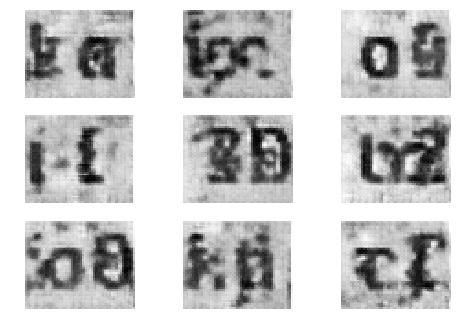

1651 [D loss: 0.850869] [G loss: 1.221119]
1652 [D loss: 0.566161] [G loss: 1.432158]
1653 [D loss: 0.923372] [G loss: 0.978913]
1654 [D loss: 0.682632] [G loss: 1.336653]
1655 [D loss: 0.841341] [G loss: 1.510594]
1656 [D loss: 0.742592] [G loss: 1.154934]
1657 [D loss: 0.703520] [G loss: 1.171687]
1658 [D loss: 1.120198] [G loss: 1.410331]
1659 [D loss: 0.798017] [G loss: 1.350357]
1660 [D loss: 0.794759] [G loss: 1.393078]
1661 [D loss: 0.710506] [G loss: 1.335922]
1662 [D loss: 0.683291] [G loss: 1.246751]
1663 [D loss: 0.630208] [G loss: 1.082825]
1664 [D loss: 0.610131] [G loss: 1.280778]
1665 [D loss: 0.875524] [G loss: 1.124376]
1666 [D loss: 0.608415] [G loss: 1.302405]
1667 [D loss: 0.612601] [G loss: 1.454575]
1668 [D loss: 0.609547] [G loss: 1.521496]
1669 [D loss: 0.745787] [G loss: 1.386012]
1670 [D loss: 0.746235] [G loss: 1.790955]
1671 [D loss: 0.566681] [G loss: 1.613806]
1672 [D loss: 1.053398] [G loss: 1.128348]
1673 [D loss: 0.855019] [G loss: 1.043540]
1674 [D los

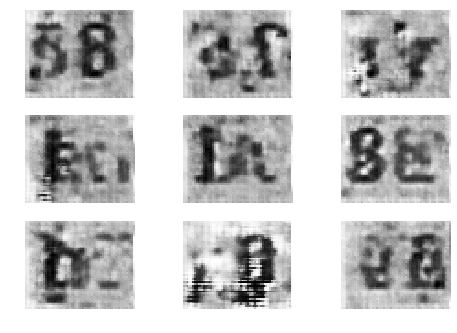

1701 [D loss: 0.799625] [G loss: 1.159113]
1702 [D loss: 0.830524] [G loss: 1.203811]
1703 [D loss: 0.692027] [G loss: 1.275634]
1704 [D loss: 0.676106] [G loss: 1.529215]
1705 [D loss: 0.922994] [G loss: 1.064285]
1706 [D loss: 0.727712] [G loss: 1.238450]
1707 [D loss: 0.722785] [G loss: 1.343432]
1708 [D loss: 0.844187] [G loss: 1.402914]
1709 [D loss: 0.653301] [G loss: 1.256195]
1710 [D loss: 0.677319] [G loss: 1.404391]
1711 [D loss: 0.819038] [G loss: 1.247418]
1712 [D loss: 0.772606] [G loss: 1.038530]
1713 [D loss: 0.664699] [G loss: 1.188042]
1714 [D loss: 0.751500] [G loss: 1.100383]
1715 [D loss: 0.694321] [G loss: 1.447605]
1716 [D loss: 0.632343] [G loss: 1.402785]
1717 [D loss: 0.725051] [G loss: 1.177377]
1718 [D loss: 0.657211] [G loss: 1.211124]
1719 [D loss: 0.883031] [G loss: 1.396161]
1720 [D loss: 0.768268] [G loss: 1.125717]
1721 [D loss: 0.904980] [G loss: 1.316745]
1722 [D loss: 0.697715] [G loss: 1.360309]
1723 [D loss: 0.810859] [G loss: 1.143270]
1724 [D los

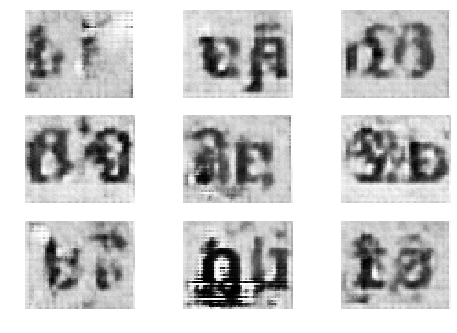

1751 [D loss: 0.844252] [G loss: 1.223168]
1752 [D loss: 0.837821] [G loss: 0.978693]
1753 [D loss: 0.934748] [G loss: 0.686204]
1754 [D loss: 0.998626] [G loss: 1.100446]
1755 [D loss: 0.874687] [G loss: 0.949673]
1756 [D loss: 0.940429] [G loss: 0.983191]
1757 [D loss: 0.724134] [G loss: 1.236252]
1758 [D loss: 0.602765] [G loss: 1.201568]
1759 [D loss: 0.805041] [G loss: 1.197630]
1760 [D loss: 0.645653] [G loss: 1.390952]
1761 [D loss: 0.706102] [G loss: 1.498313]
1762 [D loss: 0.826436] [G loss: 1.330019]
1763 [D loss: 0.798114] [G loss: 1.327570]
1764 [D loss: 0.776621] [G loss: 1.185272]
1765 [D loss: 0.731279] [G loss: 0.954503]
1766 [D loss: 0.734429] [G loss: 1.112067]
1767 [D loss: 0.731069] [G loss: 0.904642]
1768 [D loss: 0.776630] [G loss: 1.225214]
1769 [D loss: 0.947800] [G loss: 1.099628]
1770 [D loss: 0.747326] [G loss: 1.238818]
1771 [D loss: 0.732378] [G loss: 1.184383]
1772 [D loss: 0.653020] [G loss: 1.409070]
1773 [D loss: 0.700675] [G loss: 1.240143]
1774 [D los

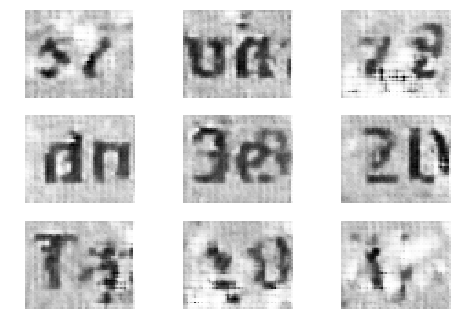

1801 [D loss: 0.762070] [G loss: 0.880575]
1802 [D loss: 0.974940] [G loss: 1.111764]
1803 [D loss: 0.709524] [G loss: 1.315155]
1804 [D loss: 0.691131] [G loss: 1.492778]
1805 [D loss: 0.992663] [G loss: 1.080947]
1806 [D loss: 0.671393] [G loss: 1.044291]
1807 [D loss: 0.685933] [G loss: 0.965942]
1808 [D loss: 0.776608] [G loss: 1.272630]
1809 [D loss: 0.846470] [G loss: 1.175198]
1810 [D loss: 0.619767] [G loss: 1.280082]
1811 [D loss: 0.805519] [G loss: 1.422166]
1812 [D loss: 0.521470] [G loss: 1.513668]
1813 [D loss: 0.631747] [G loss: 1.640030]
1814 [D loss: 0.890274] [G loss: 1.238914]
1815 [D loss: 0.823390] [G loss: 1.096372]
1816 [D loss: 0.728090] [G loss: 1.352580]
1817 [D loss: 0.868232] [G loss: 1.166793]
1818 [D loss: 0.801785] [G loss: 1.144131]
1819 [D loss: 0.806911] [G loss: 1.296939]
1820 [D loss: 0.778555] [G loss: 1.335284]
1821 [D loss: 0.700677] [G loss: 1.368958]
1822 [D loss: 1.022131] [G loss: 1.045258]
1823 [D loss: 0.677050] [G loss: 1.344295]
1824 [D los

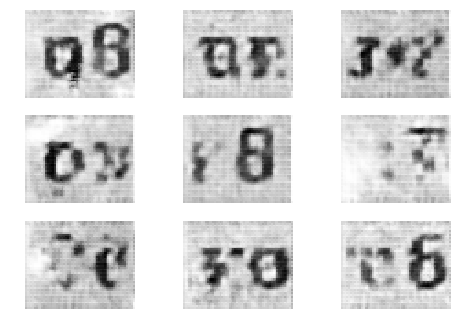

1851 [D loss: 0.804039] [G loss: 0.946261]
1852 [D loss: 0.913050] [G loss: 1.102700]
1853 [D loss: 0.713006] [G loss: 1.336646]
1854 [D loss: 0.762121] [G loss: 1.067261]
1855 [D loss: 0.735615] [G loss: 1.152301]
1856 [D loss: 0.751260] [G loss: 1.368876]
1857 [D loss: 0.625843] [G loss: 1.823415]
1858 [D loss: 0.595037] [G loss: 1.217127]
1859 [D loss: 0.856694] [G loss: 1.265242]
1860 [D loss: 0.964052] [G loss: 1.010153]
1861 [D loss: 0.544210] [G loss: 1.517591]
1862 [D loss: 0.666659] [G loss: 1.372268]
1863 [D loss: 0.602967] [G loss: 1.720757]
1864 [D loss: 1.033555] [G loss: 1.051460]
1865 [D loss: 0.626037] [G loss: 1.338914]
1866 [D loss: 0.811220] [G loss: 1.420128]
1867 [D loss: 0.817346] [G loss: 1.476166]
1868 [D loss: 0.681460] [G loss: 1.632073]
1869 [D loss: 0.775158] [G loss: 1.548764]
1870 [D loss: 0.694272] [G loss: 1.288653]
1871 [D loss: 0.568736] [G loss: 1.181829]
1872 [D loss: 0.709175] [G loss: 0.946651]
1873 [D loss: 0.769143] [G loss: 1.168905]
1874 [D los

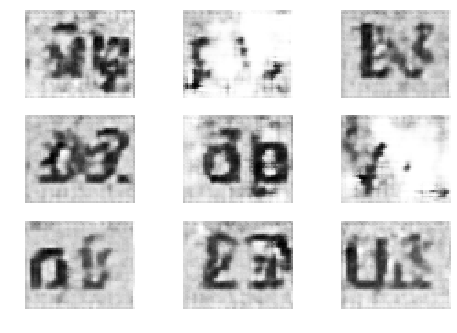

1901 [D loss: 0.648327] [G loss: 1.357355]
1902 [D loss: 0.936750] [G loss: 1.406181]
1903 [D loss: 0.661618] [G loss: 1.118034]
1904 [D loss: 0.671278] [G loss: 1.400818]
1905 [D loss: 0.710555] [G loss: 1.074376]
1906 [D loss: 0.749679] [G loss: 1.423366]
1907 [D loss: 0.807303] [G loss: 1.375836]
1908 [D loss: 0.660953] [G loss: 1.237643]
1909 [D loss: 0.710114] [G loss: 1.180882]
1910 [D loss: 0.790982] [G loss: 1.087119]
1911 [D loss: 1.044288] [G loss: 0.877349]
1912 [D loss: 0.551629] [G loss: 1.165668]
1913 [D loss: 0.803803] [G loss: 1.167020]
1914 [D loss: 0.732187] [G loss: 1.385228]
1915 [D loss: 0.627159] [G loss: 1.798517]
1916 [D loss: 0.613964] [G loss: 1.640476]
1917 [D loss: 0.674235] [G loss: 1.432614]
1918 [D loss: 0.745896] [G loss: 1.149305]
1919 [D loss: 0.918472] [G loss: 1.236305]
1920 [D loss: 0.646750] [G loss: 1.565823]
1921 [D loss: 0.949563] [G loss: 1.454116]
1922 [D loss: 0.902012] [G loss: 1.201203]
1923 [D loss: 0.657132] [G loss: 1.149888]
1924 [D los

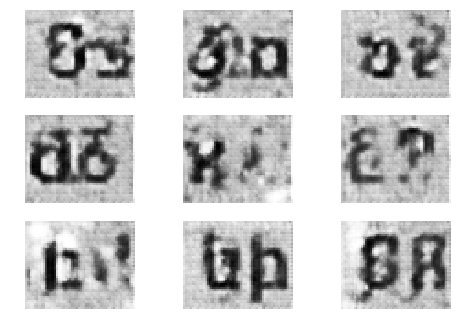

1951 [D loss: 0.669348] [G loss: 1.252116]
1952 [D loss: 0.886162] [G loss: 1.161643]
1953 [D loss: 0.646083] [G loss: 1.353689]
1954 [D loss: 0.495573] [G loss: 1.536204]
1955 [D loss: 0.852454] [G loss: 1.088838]
1956 [D loss: 0.843750] [G loss: 1.119942]
1957 [D loss: 0.575606] [G loss: 1.334201]
1958 [D loss: 0.795433] [G loss: 1.084832]
1959 [D loss: 0.825757] [G loss: 1.067618]
1960 [D loss: 0.609629] [G loss: 1.314599]
1961 [D loss: 0.773982] [G loss: 1.263816]
1962 [D loss: 0.649380] [G loss: 1.293359]
1963 [D loss: 0.772225] [G loss: 1.453371]
1964 [D loss: 0.831788] [G loss: 1.109132]
1965 [D loss: 0.779301] [G loss: 1.114698]
1966 [D loss: 0.885726] [G loss: 1.118778]
1967 [D loss: 0.509734] [G loss: 1.427755]
1968 [D loss: 0.792250] [G loss: 1.049583]
1969 [D loss: 0.617281] [G loss: 1.053454]
1970 [D loss: 0.604035] [G loss: 1.147571]
1971 [D loss: 0.738006] [G loss: 1.542141]
1972 [D loss: 0.706535] [G loss: 1.456421]
1973 [D loss: 0.751042] [G loss: 1.341156]
1974 [D los

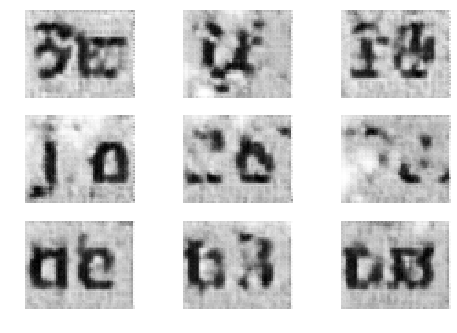

2001 [D loss: 0.836881] [G loss: 1.003258]
2002 [D loss: 0.827862] [G loss: 1.420528]
2003 [D loss: 0.635868] [G loss: 1.584980]
2004 [D loss: 0.652244] [G loss: 1.898836]
2005 [D loss: 0.708692] [G loss: 1.409811]
2006 [D loss: 0.649803] [G loss: 1.460452]
2007 [D loss: 0.735098] [G loss: 1.098378]
2008 [D loss: 0.832341] [G loss: 1.500890]
2009 [D loss: 0.613683] [G loss: 1.408513]
2010 [D loss: 0.664270] [G loss: 1.328052]
2011 [D loss: 0.552850] [G loss: 1.373549]
2012 [D loss: 0.801735] [G loss: 1.680228]
2013 [D loss: 0.988861] [G loss: 1.255758]
2014 [D loss: 0.461786] [G loss: 1.681811]
2015 [D loss: 0.846114] [G loss: 1.170214]
2016 [D loss: 0.654662] [G loss: 1.393149]
2017 [D loss: 1.144177] [G loss: 1.065983]
2018 [D loss: 0.544610] [G loss: 1.275961]
2019 [D loss: 0.598579] [G loss: 1.474131]
2020 [D loss: 0.780988] [G loss: 1.586543]
2021 [D loss: 0.781274] [G loss: 1.298362]
2022 [D loss: 0.860415] [G loss: 1.140577]
2023 [D loss: 0.691511] [G loss: 1.313430]
2024 [D los

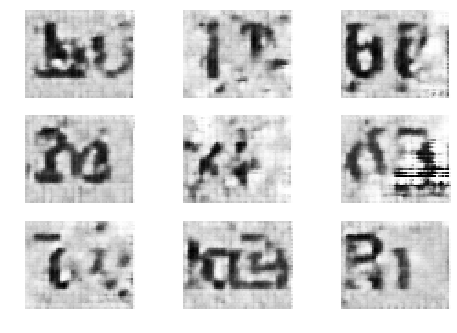

2051 [D loss: 0.835868] [G loss: 1.073772]
2052 [D loss: 0.824229] [G loss: 1.386547]
2053 [D loss: 0.662037] [G loss: 1.372715]
2054 [D loss: 0.636574] [G loss: 1.538192]
2055 [D loss: 0.751818] [G loss: 1.395669]
2056 [D loss: 0.624813] [G loss: 1.169917]
2057 [D loss: 0.916234] [G loss: 1.184167]
2058 [D loss: 0.623367] [G loss: 1.265955]
2059 [D loss: 0.570441] [G loss: 1.638621]
2060 [D loss: 1.002217] [G loss: 1.422040]
2061 [D loss: 0.747463] [G loss: 1.672979]
2062 [D loss: 0.653123] [G loss: 1.443720]
2063 [D loss: 0.738668] [G loss: 1.409810]
2064 [D loss: 0.692768] [G loss: 1.300011]
2065 [D loss: 0.718763] [G loss: 1.026340]
2066 [D loss: 0.725078] [G loss: 0.944835]
2067 [D loss: 0.777020] [G loss: 1.223763]
2068 [D loss: 0.558249] [G loss: 1.662940]
2069 [D loss: 0.890499] [G loss: 1.439465]
2070 [D loss: 0.901015] [G loss: 1.027235]
2071 [D loss: 0.665330] [G loss: 1.123613]
2072 [D loss: 0.755802] [G loss: 1.370327]
2073 [D loss: 0.709835] [G loss: 1.344478]
2074 [D los

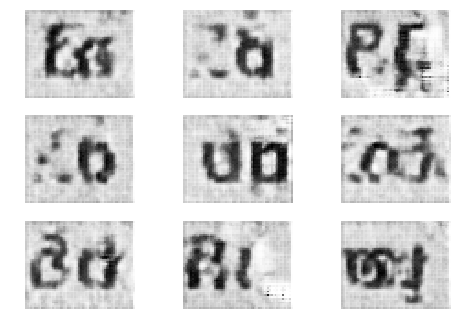

2101 [D loss: 0.664140] [G loss: 1.535049]
2102 [D loss: 0.826432] [G loss: 1.163310]
2103 [D loss: 0.631475] [G loss: 1.485797]
2104 [D loss: 0.863498] [G loss: 1.459620]
2105 [D loss: 0.863589] [G loss: 1.084906]
2106 [D loss: 0.631784] [G loss: 1.278680]
2107 [D loss: 0.716306] [G loss: 1.200705]
2108 [D loss: 0.994098] [G loss: 1.255956]
2109 [D loss: 0.673569] [G loss: 1.588583]
2110 [D loss: 0.641530] [G loss: 1.085017]
2111 [D loss: 0.947727] [G loss: 1.124127]
2112 [D loss: 0.600424] [G loss: 1.571266]
2113 [D loss: 0.783732] [G loss: 1.060509]
2114 [D loss: 0.724104] [G loss: 1.573206]
2115 [D loss: 0.578882] [G loss: 1.267755]
2116 [D loss: 0.884688] [G loss: 1.310855]
2117 [D loss: 0.724099] [G loss: 1.319113]
2118 [D loss: 1.003867] [G loss: 1.206473]
2119 [D loss: 0.498789] [G loss: 1.216421]
2120 [D loss: 0.702775] [G loss: 1.465167]
2121 [D loss: 0.768599] [G loss: 1.300201]
2122 [D loss: 0.580890] [G loss: 1.489329]
2123 [D loss: 0.769542] [G loss: 1.263783]
2124 [D los

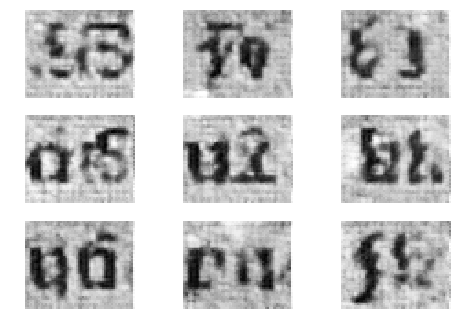

2151 [D loss: 0.699304] [G loss: 1.031020]
2152 [D loss: 0.774916] [G loss: 1.469607]
2153 [D loss: 0.686528] [G loss: 1.688473]
2154 [D loss: 0.630072] [G loss: 1.320086]
2155 [D loss: 0.663924] [G loss: 1.207169]
2156 [D loss: 0.805445] [G loss: 1.341173]
2157 [D loss: 0.649999] [G loss: 1.248304]
2158 [D loss: 0.749903] [G loss: 1.301802]
2159 [D loss: 0.606529] [G loss: 1.288093]
2160 [D loss: 0.729274] [G loss: 1.142980]
2161 [D loss: 0.654872] [G loss: 2.092052]
2162 [D loss: 0.844982] [G loss: 1.088212]
2163 [D loss: 0.518593] [G loss: 1.314729]
2164 [D loss: 0.641213] [G loss: 1.553366]
2165 [D loss: 0.675077] [G loss: 1.414750]
2166 [D loss: 0.772777] [G loss: 1.082831]
2167 [D loss: 0.749607] [G loss: 1.500633]
2168 [D loss: 0.828589] [G loss: 1.115580]
2169 [D loss: 0.819846] [G loss: 1.208270]
2170 [D loss: 0.589000] [G loss: 1.208581]
2171 [D loss: 0.544604] [G loss: 1.445346]
2172 [D loss: 0.600193] [G loss: 1.411345]
2173 [D loss: 0.802445] [G loss: 1.138345]
2174 [D los

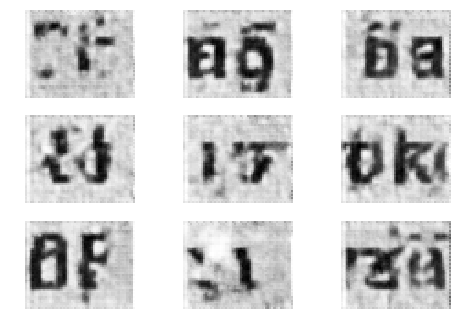

2201 [D loss: 0.738036] [G loss: 1.308619]
2202 [D loss: 0.756466] [G loss: 1.433032]
2203 [D loss: 0.623866] [G loss: 1.318403]
2204 [D loss: 0.644372] [G loss: 1.885065]
2205 [D loss: 0.717321] [G loss: 1.467540]
2206 [D loss: 0.920829] [G loss: 1.115552]
2207 [D loss: 0.617804] [G loss: 1.284071]
2208 [D loss: 0.845275] [G loss: 1.430320]
2209 [D loss: 0.925799] [G loss: 1.591290]
2210 [D loss: 0.860978] [G loss: 1.354553]
2211 [D loss: 0.574407] [G loss: 1.584618]
2212 [D loss: 0.469389] [G loss: 1.553649]
2213 [D loss: 0.626730] [G loss: 1.418761]
2214 [D loss: 0.641081] [G loss: 1.012521]
2215 [D loss: 0.961312] [G loss: 1.227929]
2216 [D loss: 0.599867] [G loss: 1.102236]
2217 [D loss: 0.794445] [G loss: 1.506237]
2218 [D loss: 0.537331] [G loss: 1.349423]
2219 [D loss: 0.629029] [G loss: 1.423348]
2220 [D loss: 0.689067] [G loss: 1.151003]
2221 [D loss: 0.671130] [G loss: 1.004095]
2222 [D loss: 0.741063] [G loss: 1.045503]
2223 [D loss: 0.584235] [G loss: 1.512408]
2224 [D los

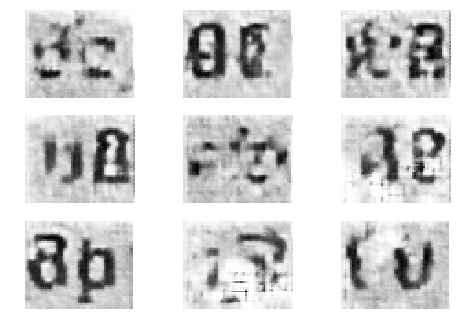

2251 [D loss: 0.742714] [G loss: 1.617113]
2252 [D loss: 0.678579] [G loss: 1.290630]
2253 [D loss: 0.618330] [G loss: 1.228263]
2254 [D loss: 0.621806] [G loss: 1.572537]
2255 [D loss: 1.053071] [G loss: 1.193118]
2256 [D loss: 0.738688] [G loss: 1.351326]
2257 [D loss: 0.821988] [G loss: 1.187825]
2258 [D loss: 0.767857] [G loss: 1.279980]
2259 [D loss: 0.519425] [G loss: 1.475101]
2260 [D loss: 0.556023] [G loss: 1.933247]
2261 [D loss: 0.985275] [G loss: 1.128601]
2262 [D loss: 0.605093] [G loss: 1.473457]
2263 [D loss: 0.648878] [G loss: 1.284552]
2264 [D loss: 0.626845] [G loss: 1.178708]
2265 [D loss: 0.652514] [G loss: 1.447188]
2266 [D loss: 0.775745] [G loss: 1.653313]
2267 [D loss: 0.700316] [G loss: 1.452065]
2268 [D loss: 0.856654] [G loss: 1.239872]
2269 [D loss: 0.724030] [G loss: 1.245783]
2270 [D loss: 0.861115] [G loss: 1.045997]
2271 [D loss: 0.752839] [G loss: 1.259073]
2272 [D loss: 0.839339] [G loss: 1.231401]
2273 [D loss: 0.704026] [G loss: 1.405701]
2274 [D los

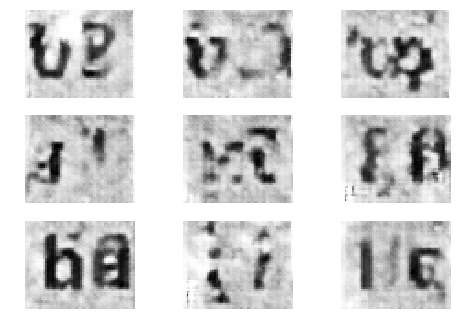

2301 [D loss: 0.871369] [G loss: 0.971683]
2302 [D loss: 0.857798] [G loss: 1.226363]
2303 [D loss: 0.856068] [G loss: 1.396031]
2304 [D loss: 0.701103] [G loss: 1.535053]
2305 [D loss: 0.836084] [G loss: 1.228853]
2306 [D loss: 0.784925] [G loss: 1.236795]
2307 [D loss: 0.832210] [G loss: 1.261507]
2308 [D loss: 0.752449] [G loss: 1.527405]
2309 [D loss: 0.978951] [G loss: 1.157577]
2310 [D loss: 0.868947] [G loss: 1.172830]
2311 [D loss: 0.710327] [G loss: 1.517179]
2312 [D loss: 0.801284] [G loss: 1.448689]
2313 [D loss: 0.892224] [G loss: 1.419702]
2314 [D loss: 0.832152] [G loss: 1.284077]
2315 [D loss: 0.827692] [G loss: 1.104442]
2316 [D loss: 0.910630] [G loss: 1.258837]
2317 [D loss: 0.760457] [G loss: 1.339467]
2318 [D loss: 0.790438] [G loss: 1.223422]
2319 [D loss: 0.654253] [G loss: 1.497864]
2320 [D loss: 0.844510] [G loss: 1.347054]
2321 [D loss: 0.694065] [G loss: 1.229166]
2322 [D loss: 0.783268] [G loss: 1.384768]
2323 [D loss: 0.892593] [G loss: 0.942946]
2324 [D los

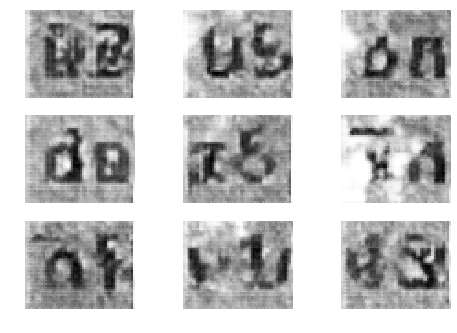

2351 [D loss: 0.683105] [G loss: 1.274303]
2352 [D loss: 0.539612] [G loss: 1.454444]
2353 [D loss: 0.473150] [G loss: 1.434178]
2354 [D loss: 0.505377] [G loss: 1.513277]
2355 [D loss: 0.936978] [G loss: 1.025130]
2356 [D loss: 0.716957] [G loss: 1.226953]
2357 [D loss: 0.703708] [G loss: 1.221615]
2358 [D loss: 0.659051] [G loss: 1.512017]
2359 [D loss: 0.455147] [G loss: 1.196863]
2360 [D loss: 0.738755] [G loss: 1.327034]
2361 [D loss: 0.435812] [G loss: 1.529969]
2362 [D loss: 0.792981] [G loss: 1.029205]
2363 [D loss: 0.649691] [G loss: 1.600083]
2364 [D loss: 0.786473] [G loss: 1.280309]
2365 [D loss: 0.570933] [G loss: 1.454062]
2366 [D loss: 0.587494] [G loss: 1.768321]
2367 [D loss: 0.495039] [G loss: 2.042572]
2368 [D loss: 0.692287] [G loss: 1.581475]
2369 [D loss: 0.841637] [G loss: 1.323809]
2370 [D loss: 0.852429] [G loss: 1.095827]
2371 [D loss: 0.780399] [G loss: 0.969418]
2372 [D loss: 0.529855] [G loss: 1.640852]
2373 [D loss: 0.544870] [G loss: 1.533647]
2374 [D los

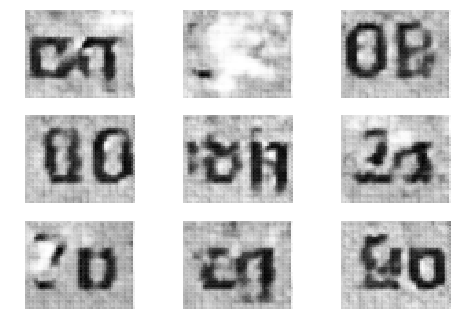

2401 [D loss: 0.504046] [G loss: 1.630651]
2402 [D loss: 0.905877] [G loss: 1.361386]
2403 [D loss: 0.618796] [G loss: 1.569155]
2404 [D loss: 0.670177] [G loss: 1.406788]
2405 [D loss: 1.134843] [G loss: 1.047821]
2406 [D loss: 0.608148] [G loss: 1.420509]
2407 [D loss: 0.575256] [G loss: 1.798481]
2408 [D loss: 0.798334] [G loss: 0.946616]
2409 [D loss: 0.766533] [G loss: 1.292978]
2410 [D loss: 0.661868] [G loss: 0.922484]
2411 [D loss: 0.670065] [G loss: 1.392138]
2412 [D loss: 0.732679] [G loss: 1.410111]
2413 [D loss: 0.633909] [G loss: 1.502619]
2414 [D loss: 0.660767] [G loss: 1.414953]
2415 [D loss: 0.658262] [G loss: 1.454605]
2416 [D loss: 0.852989] [G loss: 0.867148]
2417 [D loss: 0.720868] [G loss: 0.896754]
2418 [D loss: 0.603924] [G loss: 1.191261]
2419 [D loss: 0.575850] [G loss: 1.828008]
2420 [D loss: 0.704041] [G loss: 1.335703]
2421 [D loss: 0.568398] [G loss: 1.384058]
2422 [D loss: 0.745884] [G loss: 1.594271]
2423 [D loss: 0.770387] [G loss: 1.130879]
2424 [D los

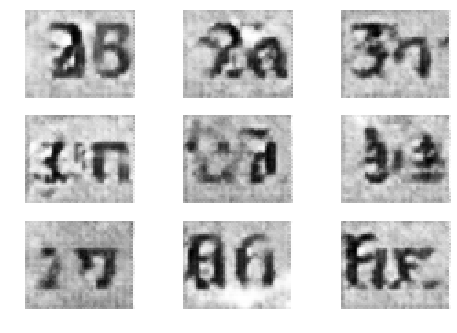

2451 [D loss: 0.404062] [G loss: 1.399337]
2452 [D loss: 0.871152] [G loss: 0.976726]
2453 [D loss: 0.512179] [G loss: 1.295476]
2454 [D loss: 0.484710] [G loss: 1.812086]
2455 [D loss: 0.759724] [G loss: 1.365632]
2456 [D loss: 0.519854] [G loss: 1.631559]
2457 [D loss: 0.746119] [G loss: 1.416062]
2458 [D loss: 0.617464] [G loss: 1.300925]
2459 [D loss: 0.483141] [G loss: 1.693367]
2460 [D loss: 0.700815] [G loss: 1.317899]
2461 [D loss: 0.951754] [G loss: 1.018877]
2462 [D loss: 0.909183] [G loss: 1.179047]
2463 [D loss: 0.538367] [G loss: 1.358278]
2464 [D loss: 0.494536] [G loss: 1.644337]
2465 [D loss: 0.844580] [G loss: 1.026540]
2466 [D loss: 0.738962] [G loss: 0.725804]
2467 [D loss: 0.562439] [G loss: 1.011083]
2468 [D loss: 0.854794] [G loss: 0.918380]
2469 [D loss: 0.526964] [G loss: 1.341577]
2470 [D loss: 0.584462] [G loss: 1.496320]
2471 [D loss: 0.838718] [G loss: 0.894955]
2472 [D loss: 0.932241] [G loss: 0.832397]
2473 [D loss: 0.759614] [G loss: 0.920992]
2474 [D los

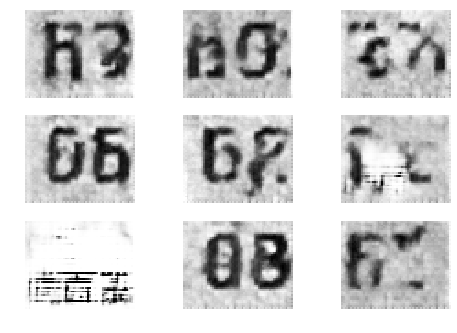

2501 [D loss: 0.844129] [G loss: 1.172177]
2502 [D loss: 0.684985] [G loss: 0.952275]
2503 [D loss: 0.651573] [G loss: 1.148048]
2504 [D loss: 0.717558] [G loss: 1.150542]
2505 [D loss: 0.744337] [G loss: 1.206885]
2506 [D loss: 0.862835] [G loss: 1.231950]
2507 [D loss: 0.909687] [G loss: 1.501409]
2508 [D loss: 0.871067] [G loss: 1.481111]
2509 [D loss: 0.555546] [G loss: 1.536146]
2510 [D loss: 0.796391] [G loss: 1.554752]
2511 [D loss: 0.753318] [G loss: 1.449502]
2512 [D loss: 0.655615] [G loss: 1.481778]
2513 [D loss: 0.689057] [G loss: 1.463622]
2514 [D loss: 0.590640] [G loss: 1.488906]
2515 [D loss: 0.847145] [G loss: 1.298101]
2516 [D loss: 0.747189] [G loss: 0.906257]
2517 [D loss: 0.589030] [G loss: 1.113830]
2518 [D loss: 0.664630] [G loss: 1.551893]
2519 [D loss: 0.692629] [G loss: 1.636124]
2520 [D loss: 0.478037] [G loss: 1.697276]
2521 [D loss: 0.759372] [G loss: 1.298975]
2522 [D loss: 0.651091] [G loss: 1.249992]
2523 [D loss: 0.568752] [G loss: 1.839393]
2524 [D los

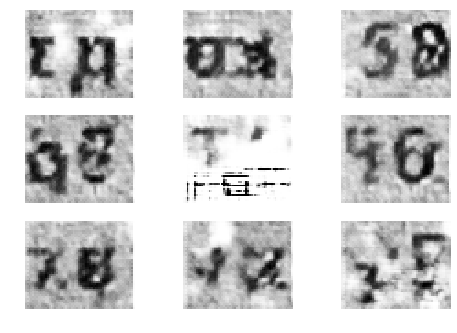

2551 [D loss: 0.740152] [G loss: 1.218152]
2552 [D loss: 0.709161] [G loss: 1.262816]
2553 [D loss: 0.645538] [G loss: 1.642348]
2554 [D loss: 0.619894] [G loss: 1.125366]
2555 [D loss: 0.640968] [G loss: 1.383727]
2556 [D loss: 0.568460] [G loss: 1.130532]
2557 [D loss: 0.731799] [G loss: 1.342160]
2558 [D loss: 0.688750] [G loss: 1.511696]
2559 [D loss: 0.756413] [G loss: 1.336332]
2560 [D loss: 0.610406] [G loss: 1.391767]
2561 [D loss: 0.628562] [G loss: 1.494270]
2562 [D loss: 0.764465] [G loss: 1.130981]
2563 [D loss: 0.798553] [G loss: 1.318760]
2564 [D loss: 0.826781] [G loss: 1.281448]
2565 [D loss: 0.718792] [G loss: 1.534857]
2566 [D loss: 0.558234] [G loss: 1.704733]
2567 [D loss: 0.708998] [G loss: 1.440504]
2568 [D loss: 0.792475] [G loss: 1.002593]
2569 [D loss: 0.521492] [G loss: 1.209978]
2570 [D loss: 0.708579] [G loss: 1.230275]
2571 [D loss: 0.607054] [G loss: 1.299446]
2572 [D loss: 0.796658] [G loss: 1.433325]
2573 [D loss: 0.520600] [G loss: 1.720536]
2574 [D los

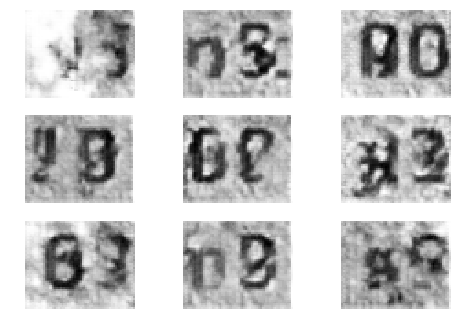

2601 [D loss: 0.708973] [G loss: 1.599617]
2602 [D loss: 0.823469] [G loss: 1.085318]
2603 [D loss: 0.860356] [G loss: 0.989745]
2604 [D loss: 0.523418] [G loss: 1.348235]
2605 [D loss: 0.638160] [G loss: 1.414305]
2606 [D loss: 0.972731] [G loss: 1.157801]
2607 [D loss: 0.602562] [G loss: 1.185944]
2608 [D loss: 0.628606] [G loss: 1.286195]
2609 [D loss: 0.665042] [G loss: 1.196533]
2610 [D loss: 0.707695] [G loss: 1.170198]
2611 [D loss: 0.803541] [G loss: 1.813873]
2612 [D loss: 0.774408] [G loss: 1.237221]
2613 [D loss: 0.768842] [G loss: 0.925371]
2614 [D loss: 0.759764] [G loss: 1.342578]
2615 [D loss: 0.926202] [G loss: 1.314892]
2616 [D loss: 0.693978] [G loss: 1.515761]
2617 [D loss: 0.633630] [G loss: 1.263435]
2618 [D loss: 0.862314] [G loss: 1.502636]
2619 [D loss: 0.691073] [G loss: 1.410213]
2620 [D loss: 0.839756] [G loss: 1.326873]
2621 [D loss: 0.785193] [G loss: 1.447463]
2622 [D loss: 0.753290] [G loss: 1.076726]
2623 [D loss: 0.775300] [G loss: 1.443381]
2624 [D los

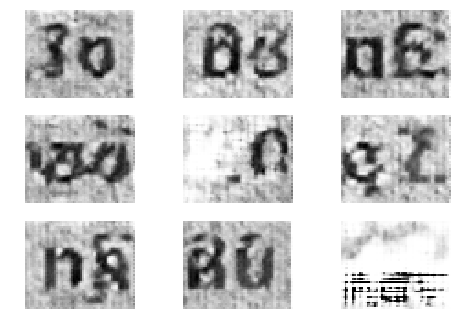

2651 [D loss: 0.651036] [G loss: 1.185005]
2652 [D loss: 0.724196] [G loss: 1.070462]
2653 [D loss: 0.684478] [G loss: 1.431261]
2654 [D loss: 0.518063] [G loss: 1.474338]
2655 [D loss: 0.757785] [G loss: 1.483158]
2656 [D loss: 0.571036] [G loss: 1.521087]
2657 [D loss: 0.858701] [G loss: 1.105496]
2658 [D loss: 0.601575] [G loss: 1.117275]
2659 [D loss: 0.887108] [G loss: 1.155841]
2660 [D loss: 0.871517] [G loss: 1.188728]
2661 [D loss: 0.741619] [G loss: 1.759452]
2662 [D loss: 0.862110] [G loss: 1.653180]
2663 [D loss: 0.473166] [G loss: 1.651121]
2664 [D loss: 0.674118] [G loss: 1.146098]
2665 [D loss: 0.555589] [G loss: 1.721413]
2666 [D loss: 0.649780] [G loss: 1.499748]
2667 [D loss: 0.644068] [G loss: 1.373018]
2668 [D loss: 0.709687] [G loss: 1.086604]
2669 [D loss: 0.711348] [G loss: 1.531682]
2670 [D loss: 0.813749] [G loss: 1.362665]
2671 [D loss: 0.728207] [G loss: 1.729296]
2672 [D loss: 0.662749] [G loss: 1.651149]
2673 [D loss: 0.621373] [G loss: 1.305832]
2674 [D los

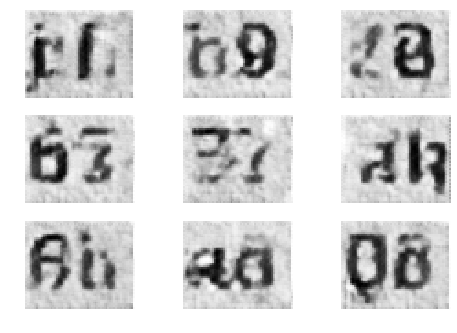

2701 [D loss: 0.631541] [G loss: 0.971968]
2702 [D loss: 0.575667] [G loss: 1.305513]
2703 [D loss: 0.750082] [G loss: 1.562680]
2704 [D loss: 0.757079] [G loss: 1.633534]
2705 [D loss: 0.646532] [G loss: 1.193905]
2706 [D loss: 0.694408] [G loss: 1.087853]
2707 [D loss: 0.676123] [G loss: 1.756013]
2708 [D loss: 0.679838] [G loss: 1.822948]
2709 [D loss: 0.786128] [G loss: 1.632549]
2710 [D loss: 0.647370] [G loss: 1.646242]
2711 [D loss: 0.799282] [G loss: 1.348081]
2712 [D loss: 0.800953] [G loss: 1.373182]
2713 [D loss: 0.860266] [G loss: 1.175714]
2714 [D loss: 0.704685] [G loss: 1.256902]
2715 [D loss: 0.567401] [G loss: 1.001841]
2716 [D loss: 0.546527] [G loss: 1.621610]
2717 [D loss: 0.739988] [G loss: 1.322068]
2718 [D loss: 0.656430] [G loss: 1.280127]
2719 [D loss: 0.693765] [G loss: 1.546105]
2720 [D loss: 0.819297] [G loss: 1.294248]
2721 [D loss: 0.682515] [G loss: 1.608394]
2722 [D loss: 0.776221] [G loss: 1.706450]
2723 [D loss: 0.950436] [G loss: 1.331922]
2724 [D los

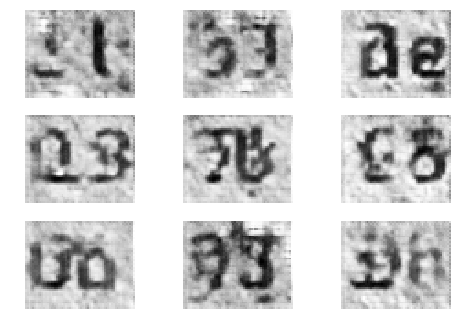

2751 [D loss: 0.730485] [G loss: 1.085147]
2752 [D loss: 0.506072] [G loss: 1.128377]
2753 [D loss: 0.863744] [G loss: 1.130625]
2754 [D loss: 0.638970] [G loss: 1.472328]
2755 [D loss: 0.810727] [G loss: 1.323990]
2756 [D loss: 0.840095] [G loss: 1.303194]
2757 [D loss: 0.702643] [G loss: 1.398640]
2758 [D loss: 0.550807] [G loss: 1.088004]
2759 [D loss: 0.712512] [G loss: 1.183693]
2760 [D loss: 0.750286] [G loss: 1.163623]
2761 [D loss: 0.627228] [G loss: 1.615534]
2762 [D loss: 0.920516] [G loss: 1.283509]
2763 [D loss: 0.883989] [G loss: 1.156998]
2764 [D loss: 0.559600] [G loss: 1.287556]
2765 [D loss: 0.649511] [G loss: 1.488575]
2766 [D loss: 0.682592] [G loss: 1.220523]
2767 [D loss: 0.811431] [G loss: 1.038260]
2768 [D loss: 0.511038] [G loss: 1.332794]
2769 [D loss: 0.551549] [G loss: 1.484564]
2770 [D loss: 0.585028] [G loss: 1.766519]
2771 [D loss: 0.791423] [G loss: 1.165045]
2772 [D loss: 0.781775] [G loss: 1.308688]
2773 [D loss: 0.554794] [G loss: 1.431784]
2774 [D los

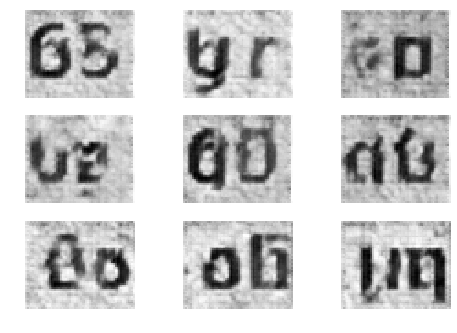

2801 [D loss: 0.574769] [G loss: 1.583961]
2802 [D loss: 0.760517] [G loss: 1.427158]
2803 [D loss: 0.595334] [G loss: 1.651103]
2804 [D loss: 0.732871] [G loss: 1.452940]
2805 [D loss: 0.551811] [G loss: 1.218215]
2806 [D loss: 0.903214] [G loss: 1.118656]
2807 [D loss: 0.522044] [G loss: 1.524318]
2808 [D loss: 0.661279] [G loss: 1.104788]
2809 [D loss: 0.616581] [G loss: 1.161609]
2810 [D loss: 0.608848] [G loss: 1.172459]
2811 [D loss: 0.811139] [G loss: 1.253499]
2812 [D loss: 0.661427] [G loss: 1.313116]
2813 [D loss: 0.634599] [G loss: 1.356288]
2814 [D loss: 0.688584] [G loss: 1.656574]
2815 [D loss: 0.720856] [G loss: 1.683710]
2816 [D loss: 0.676733] [G loss: 1.463016]
2817 [D loss: 0.678790] [G loss: 1.139131]
2818 [D loss: 0.553165] [G loss: 1.373467]
2819 [D loss: 0.471870] [G loss: 1.469284]
2820 [D loss: 0.692177] [G loss: 1.215563]
2821 [D loss: 0.483314] [G loss: 1.593578]
2822 [D loss: 0.661486] [G loss: 1.570082]
2823 [D loss: 0.595066] [G loss: 1.122182]
2824 [D los

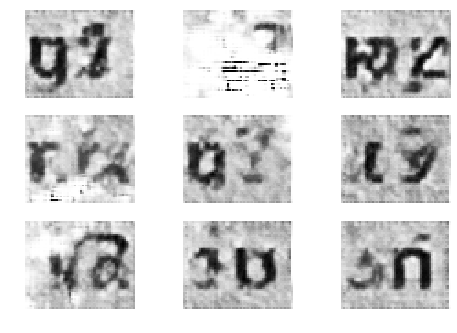

2851 [D loss: 0.518468] [G loss: 1.283323]
2852 [D loss: 0.749476] [G loss: 1.625056]
2853 [D loss: 0.710411] [G loss: 1.246231]
2854 [D loss: 0.518436] [G loss: 1.544724]
2855 [D loss: 0.669050] [G loss: 1.472041]
2856 [D loss: 0.652398] [G loss: 1.111600]
2857 [D loss: 0.636129] [G loss: 1.550312]
2858 [D loss: 0.837053] [G loss: 1.059739]
2859 [D loss: 0.723501] [G loss: 1.439450]
2860 [D loss: 0.661034] [G loss: 1.153212]
2861 [D loss: 0.712884] [G loss: 1.274990]
2862 [D loss: 0.714759] [G loss: 1.374687]
2863 [D loss: 0.861430] [G loss: 1.437160]
2864 [D loss: 0.726267] [G loss: 1.270569]
2865 [D loss: 0.605427] [G loss: 1.316250]
2866 [D loss: 0.629643] [G loss: 1.177209]
2867 [D loss: 0.739045] [G loss: 1.423539]
2868 [D loss: 0.530913] [G loss: 1.482280]
2869 [D loss: 0.616284] [G loss: 1.189683]
2870 [D loss: 0.747511] [G loss: 1.136602]
2871 [D loss: 0.687899] [G loss: 1.434392]
2872 [D loss: 0.708044] [G loss: 1.244855]
2873 [D loss: 0.709378] [G loss: 1.344280]
2874 [D los

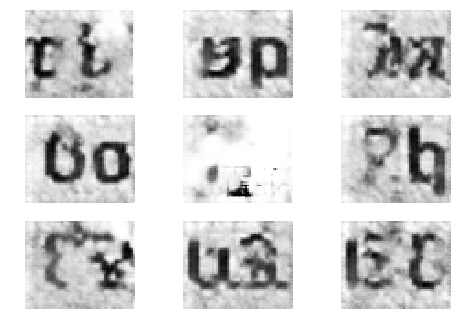

2901 [D loss: 0.747149] [G loss: 1.622920]
2902 [D loss: 0.786764] [G loss: 1.551142]
2903 [D loss: 0.605077] [G loss: 1.482394]
2904 [D loss: 0.655095] [G loss: 2.055602]
2905 [D loss: 0.732944] [G loss: 1.573576]
2906 [D loss: 0.569679] [G loss: 1.629233]
2907 [D loss: 0.639673] [G loss: 1.496824]
2908 [D loss: 0.597688] [G loss: 1.695459]
2909 [D loss: 0.749931] [G loss: 1.656983]
2910 [D loss: 0.764009] [G loss: 0.954085]
2911 [D loss: 0.739705] [G loss: 1.538263]
2912 [D loss: 0.499892] [G loss: 1.780352]
2913 [D loss: 0.700799] [G loss: 1.500348]
2914 [D loss: 0.859933] [G loss: 0.980984]
2915 [D loss: 0.749480] [G loss: 0.958683]
2916 [D loss: 0.472866] [G loss: 1.691407]
2917 [D loss: 0.721585] [G loss: 1.369372]
2918 [D loss: 0.532392] [G loss: 1.141496]
2919 [D loss: 0.701909] [G loss: 1.540799]
2920 [D loss: 0.660701] [G loss: 1.232717]
2921 [D loss: 0.730117] [G loss: 1.049082]
2922 [D loss: 0.627919] [G loss: 1.807733]
2923 [D loss: 0.613052] [G loss: 1.855920]
2924 [D los

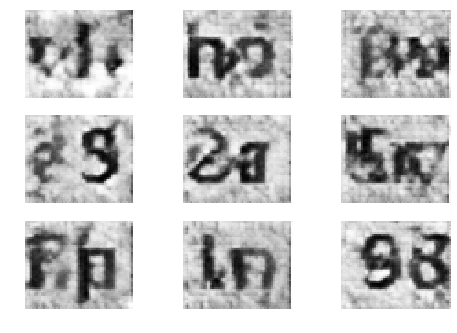

2951 [D loss: 0.543259] [G loss: 1.490320]
2952 [D loss: 0.520476] [G loss: 1.649355]
2953 [D loss: 0.631175] [G loss: 1.499931]
2954 [D loss: 0.695056] [G loss: 1.571643]
2955 [D loss: 0.506267] [G loss: 1.539498]
2956 [D loss: 0.858498] [G loss: 1.930726]
2957 [D loss: 0.525613] [G loss: 1.573377]
2958 [D loss: 0.571643] [G loss: 1.659018]
2959 [D loss: 0.832407] [G loss: 1.492186]
2960 [D loss: 0.861192] [G loss: 0.909374]
2961 [D loss: 0.511730] [G loss: 1.666958]
2962 [D loss: 0.732023] [G loss: 1.675205]
2963 [D loss: 0.710784] [G loss: 1.472735]
2964 [D loss: 0.651797] [G loss: 1.407040]
2965 [D loss: 0.898667] [G loss: 1.298821]
2966 [D loss: 0.505280] [G loss: 1.463522]
2967 [D loss: 0.747965] [G loss: 1.352157]
2968 [D loss: 0.518763] [G loss: 1.278672]
2969 [D loss: 0.778319] [G loss: 0.794438]
2970 [D loss: 0.545863] [G loss: 1.373241]
2971 [D loss: 0.573077] [G loss: 1.363838]
2972 [D loss: 0.616761] [G loss: 1.346324]
2973 [D loss: 0.647336] [G loss: 1.296274]
2974 [D los

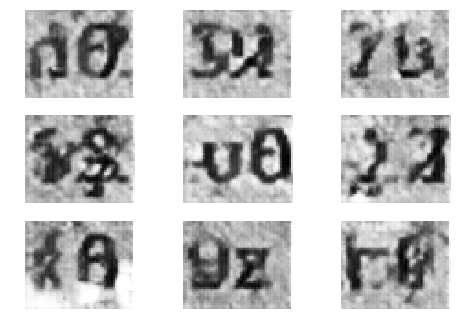

3001 [D loss: 0.559749] [G loss: 2.001260]
3002 [D loss: 0.949519] [G loss: 1.273274]
3003 [D loss: 0.586209] [G loss: 1.338904]
3004 [D loss: 0.613760] [G loss: 1.397431]
3005 [D loss: 0.417946] [G loss: 1.508031]
3006 [D loss: 0.420476] [G loss: 2.095965]
3007 [D loss: 0.514768] [G loss: 1.640570]
3008 [D loss: 0.769313] [G loss: 1.123358]
3009 [D loss: 0.818571] [G loss: 1.080307]
3010 [D loss: 0.758710] [G loss: 1.282590]
3011 [D loss: 0.698577] [G loss: 1.189681]
3012 [D loss: 0.509438] [G loss: 1.472208]
3013 [D loss: 0.500850] [G loss: 1.902495]
3014 [D loss: 0.702713] [G loss: 1.667782]
3015 [D loss: 0.604399] [G loss: 1.411549]
3016 [D loss: 0.477866] [G loss: 1.572835]
3017 [D loss: 0.674746] [G loss: 1.472511]
3018 [D loss: 0.483531] [G loss: 1.589544]
3019 [D loss: 0.551612] [G loss: 1.999565]
3020 [D loss: 0.583167] [G loss: 0.993206]
3021 [D loss: 0.588947] [G loss: 1.463842]
3022 [D loss: 0.833976] [G loss: 0.956292]
3023 [D loss: 0.465787] [G loss: 1.111479]
3024 [D los

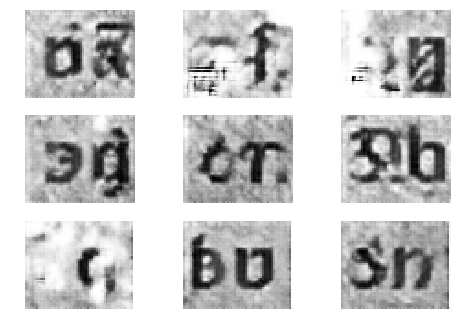

3051 [D loss: 0.871364] [G loss: 1.568660]
3052 [D loss: 0.640320] [G loss: 1.609994]
3053 [D loss: 0.729091] [G loss: 1.278088]
3054 [D loss: 0.840725] [G loss: 1.152040]
3055 [D loss: 0.661475] [G loss: 1.209200]
3056 [D loss: 0.713000] [G loss: 1.461459]
3057 [D loss: 0.702837] [G loss: 2.055946]
3058 [D loss: 0.793086] [G loss: 1.852224]
3059 [D loss: 0.617674] [G loss: 1.504905]
3060 [D loss: 0.610439] [G loss: 1.622937]
3061 [D loss: 1.009429] [G loss: 1.256407]
3062 [D loss: 0.874058] [G loss: 1.262285]
3063 [D loss: 0.758793] [G loss: 1.209399]
3064 [D loss: 0.592279] [G loss: 1.500258]
3065 [D loss: 0.661198] [G loss: 1.734029]
3066 [D loss: 0.752964] [G loss: 1.448294]
3067 [D loss: 0.789350] [G loss: 1.482326]
3068 [D loss: 0.688385] [G loss: 1.456595]
3069 [D loss: 0.784723] [G loss: 1.425619]
3070 [D loss: 0.628481] [G loss: 1.585207]
3071 [D loss: 0.550824] [G loss: 1.481286]
3072 [D loss: 0.622034] [G loss: 1.425756]
3073 [D loss: 0.691720] [G loss: 1.283827]
3074 [D los

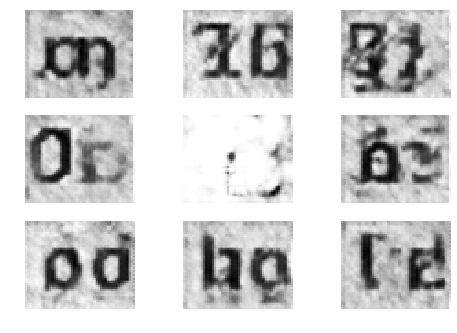

3101 [D loss: 0.568907] [G loss: 2.101421]
3102 [D loss: 0.684142] [G loss: 1.340693]
3103 [D loss: 0.505085] [G loss: 1.704803]
3104 [D loss: 0.556481] [G loss: 1.465253]
3105 [D loss: 0.520281] [G loss: 1.716141]
3106 [D loss: 0.698369] [G loss: 1.430302]
3107 [D loss: 0.443564] [G loss: 1.721922]
3108 [D loss: 0.580095] [G loss: 1.651275]
3109 [D loss: 0.777272] [G loss: 1.367090]
3110 [D loss: 0.506488] [G loss: 1.524326]
3111 [D loss: 0.505957] [G loss: 1.799279]
3112 [D loss: 0.503377] [G loss: 1.684725]
3113 [D loss: 0.878001] [G loss: 1.716085]
3114 [D loss: 0.335050] [G loss: 1.516061]
3115 [D loss: 0.385112] [G loss: 1.720191]
3116 [D loss: 0.794377] [G loss: 1.247089]
3117 [D loss: 0.783474] [G loss: 1.553512]
3118 [D loss: 0.728786] [G loss: 1.531947]
3119 [D loss: 0.591475] [G loss: 1.448134]
3120 [D loss: 0.732090] [G loss: 1.591518]
3121 [D loss: 0.387832] [G loss: 1.662793]
3122 [D loss: 0.333266] [G loss: 1.899513]
3123 [D loss: 1.024104] [G loss: 1.252409]
3124 [D los

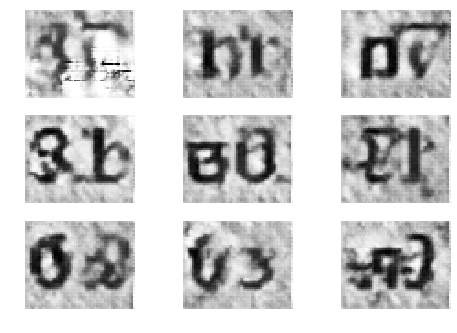

3151 [D loss: 0.853182] [G loss: 0.899416]
3152 [D loss: 0.678465] [G loss: 1.225928]
3153 [D loss: 0.591089] [G loss: 1.958383]
3154 [D loss: 0.400885] [G loss: 1.064684]
3155 [D loss: 0.707371] [G loss: 1.150504]
3156 [D loss: 0.618190] [G loss: 1.268832]
3157 [D loss: 0.704440] [G loss: 1.524642]
3158 [D loss: 0.748610] [G loss: 1.310006]
3159 [D loss: 0.739493] [G loss: 1.645172]
3160 [D loss: 0.668586] [G loss: 1.873189]
3161 [D loss: 0.575192] [G loss: 1.638278]
3162 [D loss: 0.742899] [G loss: 1.393209]
3163 [D loss: 0.519519] [G loss: 1.807372]
3164 [D loss: 0.608803] [G loss: 1.244625]
3165 [D loss: 0.488082] [G loss: 1.734088]
3166 [D loss: 0.599791] [G loss: 1.720580]
3167 [D loss: 0.649710] [G loss: 1.389587]
3168 [D loss: 0.509388] [G loss: 1.460155]
3169 [D loss: 0.454823] [G loss: 1.450810]
3170 [D loss: 0.675231] [G loss: 1.658034]
3171 [D loss: 0.633570] [G loss: 1.685495]
3172 [D loss: 0.877388] [G loss: 1.883379]
3173 [D loss: 0.812578] [G loss: 1.776340]
3174 [D los

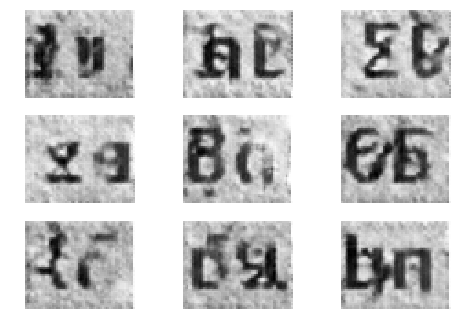

3201 [D loss: 0.658627] [G loss: 1.577213]
3202 [D loss: 0.642274] [G loss: 1.170186]
3203 [D loss: 0.584820] [G loss: 1.228519]
3204 [D loss: 0.774854] [G loss: 1.187485]
3205 [D loss: 0.643911] [G loss: 1.670711]
3206 [D loss: 0.808950] [G loss: 1.320900]
3207 [D loss: 0.699069] [G loss: 1.362172]
3208 [D loss: 0.721205] [G loss: 1.238165]
3209 [D loss: 0.522183] [G loss: 1.454242]
3210 [D loss: 0.570617] [G loss: 1.332386]
3211 [D loss: 0.753364] [G loss: 2.031432]
3212 [D loss: 0.887126] [G loss: 1.591506]
3213 [D loss: 0.693514] [G loss: 1.790004]
3214 [D loss: 0.713820] [G loss: 1.608468]
3215 [D loss: 0.865450] [G loss: 1.323460]
3216 [D loss: 0.764640] [G loss: 1.424385]
3217 [D loss: 0.525319] [G loss: 1.809323]
3218 [D loss: 0.658378] [G loss: 1.817634]
3219 [D loss: 0.585778] [G loss: 1.631443]
3220 [D loss: 0.553615] [G loss: 1.389897]
3221 [D loss: 0.746075] [G loss: 1.617970]
3222 [D loss: 0.609080] [G loss: 1.303781]
3223 [D loss: 0.673261] [G loss: 1.753932]
3224 [D los

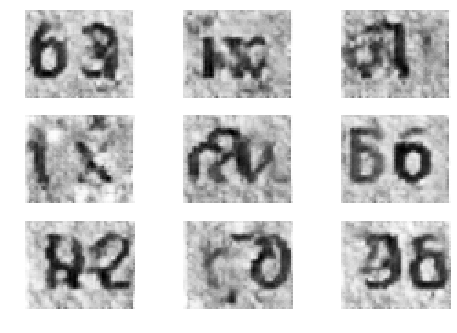

3251 [D loss: 0.750675] [G loss: 1.384057]
3252 [D loss: 0.656037] [G loss: 1.477581]
3253 [D loss: 0.389307] [G loss: 1.773600]
3254 [D loss: 0.833086] [G loss: 0.862501]
3255 [D loss: 0.760523] [G loss: 0.829041]
3256 [D loss: 0.932366] [G loss: 1.234627]
3257 [D loss: 0.872763] [G loss: 1.061595]
3258 [D loss: 0.473548] [G loss: 1.980038]
3259 [D loss: 0.614340] [G loss: 1.749668]
3260 [D loss: 0.644086] [G loss: 2.097527]
3261 [D loss: 0.634637] [G loss: 1.076776]
3262 [D loss: 0.646924] [G loss: 1.377166]
3263 [D loss: 0.637134] [G loss: 1.109316]
3264 [D loss: 0.450920] [G loss: 1.466894]
3265 [D loss: 0.706818] [G loss: 1.197942]
3266 [D loss: 0.645424] [G loss: 1.448569]
3267 [D loss: 0.779578] [G loss: 1.569948]
3268 [D loss: 0.742870] [G loss: 1.454152]
3269 [D loss: 0.624928] [G loss: 1.239155]
3270 [D loss: 0.675817] [G loss: 1.129473]
3271 [D loss: 0.594822] [G loss: 1.673525]
3272 [D loss: 0.610404] [G loss: 1.830496]
3273 [D loss: 0.643849] [G loss: 1.727813]
3274 [D los

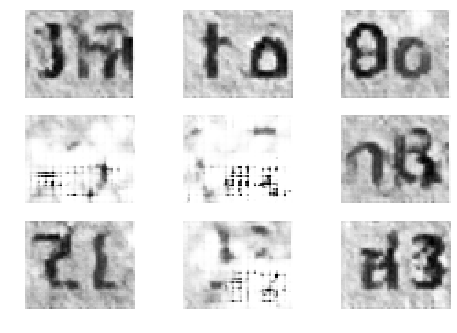

3301 [D loss: 0.622241] [G loss: 1.285298]
3302 [D loss: 0.520146] [G loss: 1.531690]
3303 [D loss: 0.562132] [G loss: 1.484291]
3304 [D loss: 0.643099] [G loss: 1.687770]
3305 [D loss: 0.646578] [G loss: 1.962987]
3306 [D loss: 0.706303] [G loss: 1.605126]
3307 [D loss: 0.646091] [G loss: 1.360509]
3308 [D loss: 0.543628] [G loss: 1.270038]
3309 [D loss: 0.659587] [G loss: 1.568476]
3310 [D loss: 0.811332] [G loss: 1.314432]
3311 [D loss: 0.534483] [G loss: 1.815905]
3312 [D loss: 0.715512] [G loss: 1.469571]
3313 [D loss: 0.433970] [G loss: 1.850996]
3314 [D loss: 0.665647] [G loss: 1.577543]
3315 [D loss: 0.575305] [G loss: 2.019736]
3316 [D loss: 0.825549] [G loss: 1.161607]
3317 [D loss: 0.618338] [G loss: 1.569891]
3318 [D loss: 0.733387] [G loss: 1.472534]
3319 [D loss: 0.479609] [G loss: 1.698839]
3320 [D loss: 0.645883] [G loss: 1.317405]
3321 [D loss: 0.602138] [G loss: 1.441899]
3322 [D loss: 0.700987] [G loss: 1.152525]
3323 [D loss: 0.710717] [G loss: 1.638140]
3324 [D los

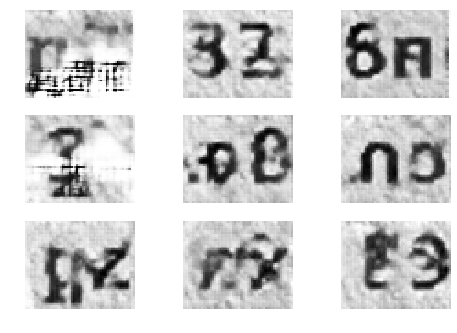

3351 [D loss: 0.557199] [G loss: 1.662827]
3352 [D loss: 0.677397] [G loss: 1.241312]
3353 [D loss: 0.651846] [G loss: 1.372873]
3354 [D loss: 0.706113] [G loss: 1.238049]
3355 [D loss: 0.580957] [G loss: 1.199892]
3356 [D loss: 0.698040] [G loss: 1.744113]
3357 [D loss: 0.650765] [G loss: 1.534873]
3358 [D loss: 0.618446] [G loss: 1.631719]
3359 [D loss: 0.526479] [G loss: 1.949724]
3360 [D loss: 0.542577] [G loss: 1.673135]
3361 [D loss: 0.670316] [G loss: 1.451041]
3362 [D loss: 0.706888] [G loss: 1.445104]
3363 [D loss: 0.439651] [G loss: 1.606891]
3364 [D loss: 0.693873] [G loss: 1.361226]
3365 [D loss: 0.716368] [G loss: 1.447694]
3366 [D loss: 0.719968] [G loss: 2.011668]
3367 [D loss: 0.703247] [G loss: 1.947624]
3368 [D loss: 0.530959] [G loss: 2.115925]
3369 [D loss: 0.583409] [G loss: 1.514924]
3370 [D loss: 0.519427] [G loss: 1.358299]
3371 [D loss: 0.481022] [G loss: 1.514213]
3372 [D loss: 0.580772] [G loss: 1.814451]
3373 [D loss: 0.615739] [G loss: 1.452904]
3374 [D los

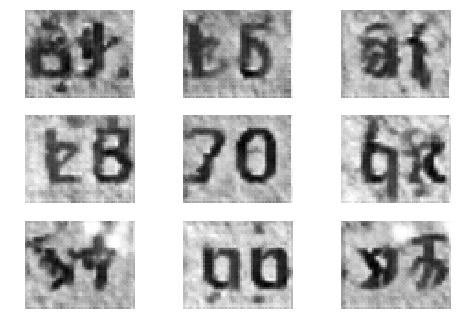

3401 [D loss: 0.378176] [G loss: 1.617041]
3402 [D loss: 0.529269] [G loss: 1.800021]
3403 [D loss: 0.708282] [G loss: 2.126053]
3404 [D loss: 0.437414] [G loss: 1.703805]
3405 [D loss: 0.532383] [G loss: 1.546434]
3406 [D loss: 0.467491] [G loss: 2.030195]
3407 [D loss: 0.688922] [G loss: 0.987761]
3408 [D loss: 0.625308] [G loss: 1.187731]
3409 [D loss: 0.598504] [G loss: 1.534240]
3410 [D loss: 0.680714] [G loss: 1.463831]
3411 [D loss: 0.846564] [G loss: 1.352552]
3412 [D loss: 0.564417] [G loss: 1.537457]
3413 [D loss: 0.560925] [G loss: 1.680467]
3414 [D loss: 0.889891] [G loss: 1.800420]
3415 [D loss: 0.592748] [G loss: 1.424060]
3416 [D loss: 0.713908] [G loss: 1.495332]
3417 [D loss: 0.568563] [G loss: 1.342815]
3418 [D loss: 0.500042] [G loss: 1.383169]
3419 [D loss: 0.676501] [G loss: 1.008093]
3420 [D loss: 0.521681] [G loss: 1.437364]
3421 [D loss: 0.481600] [G loss: 1.308531]
3422 [D loss: 0.722317] [G loss: 1.406342]
3423 [D loss: 0.543961] [G loss: 1.592520]
3424 [D los

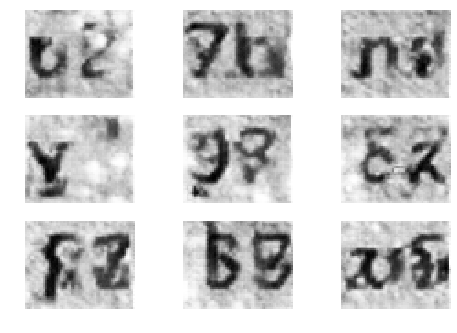

3451 [D loss: 0.507336] [G loss: 2.045603]
3452 [D loss: 0.567999] [G loss: 1.361321]
3453 [D loss: 0.649408] [G loss: 1.322750]
3454 [D loss: 0.545079] [G loss: 1.831593]
3455 [D loss: 0.717248] [G loss: 1.639577]
3456 [D loss: 0.627772] [G loss: 1.862380]
3457 [D loss: 0.663561] [G loss: 1.058545]
3458 [D loss: 0.499383] [G loss: 1.163392]
3459 [D loss: 0.547082] [G loss: 1.844308]
3460 [D loss: 0.498852] [G loss: 1.936044]
3461 [D loss: 0.595038] [G loss: 1.368888]
3462 [D loss: 0.602856] [G loss: 1.100964]
3463 [D loss: 0.472819] [G loss: 1.880993]
3464 [D loss: 0.634030] [G loss: 1.659081]
3465 [D loss: 0.626191] [G loss: 1.404231]
3466 [D loss: 0.517987] [G loss: 1.779288]
3467 [D loss: 0.534997] [G loss: 1.607747]
3468 [D loss: 0.611374] [G loss: 1.710872]
3469 [D loss: 0.646323] [G loss: 1.799787]
3470 [D loss: 0.577523] [G loss: 1.532036]
3471 [D loss: 0.592741] [G loss: 1.327044]
3472 [D loss: 0.642460] [G loss: 1.323851]
3473 [D loss: 0.663948] [G loss: 1.374225]
3474 [D los

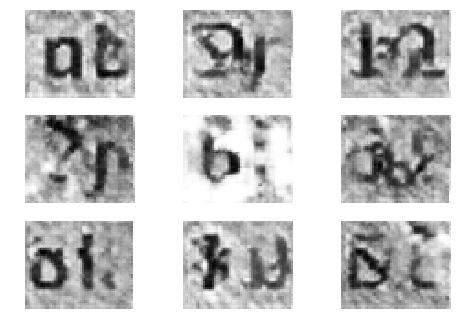

3501 [D loss: 0.590045] [G loss: 1.850656]
3502 [D loss: 0.496865] [G loss: 1.569884]
3503 [D loss: 0.610491] [G loss: 1.517379]
3504 [D loss: 0.467850] [G loss: 2.468280]
3505 [D loss: 0.862318] [G loss: 1.625664]
3506 [D loss: 0.706949] [G loss: 1.535522]
3507 [D loss: 0.396631] [G loss: 1.774584]
3508 [D loss: 0.604911] [G loss: 1.579147]
3509 [D loss: 0.592699] [G loss: 1.499183]
3510 [D loss: 0.670196] [G loss: 1.407084]
3511 [D loss: 0.518053] [G loss: 1.471370]
3512 [D loss: 0.628007] [G loss: 1.498564]
3513 [D loss: 0.571035] [G loss: 1.437798]
3514 [D loss: 0.770460] [G loss: 1.291872]
3515 [D loss: 0.654779] [G loss: 1.508747]
3516 [D loss: 0.448318] [G loss: 1.679239]
3517 [D loss: 0.736867] [G loss: 1.805764]
3518 [D loss: 0.324400] [G loss: 1.851513]
3519 [D loss: 0.526898] [G loss: 1.228870]
3520 [D loss: 0.646419] [G loss: 1.858481]
3521 [D loss: 0.603919] [G loss: 1.953682]
3522 [D loss: 0.659008] [G loss: 1.323091]
3523 [D loss: 0.721445] [G loss: 1.578208]
3524 [D los

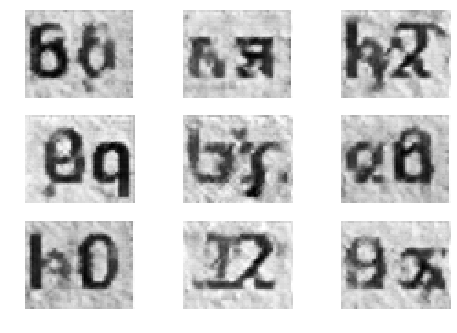

3551 [D loss: 0.515702] [G loss: 1.237012]
3552 [D loss: 0.527743] [G loss: 1.106304]
3553 [D loss: 0.537365] [G loss: 1.764406]
3554 [D loss: 0.680012] [G loss: 1.425741]
3555 [D loss: 0.719654] [G loss: 1.273942]
3556 [D loss: 0.555889] [G loss: 1.595599]
3557 [D loss: 0.553497] [G loss: 1.606400]
3558 [D loss: 0.533864] [G loss: 1.626727]
3559 [D loss: 0.788922] [G loss: 1.322520]
3560 [D loss: 0.484113] [G loss: 1.621706]
3561 [D loss: 0.697990] [G loss: 1.883481]
3562 [D loss: 0.592262] [G loss: 1.886338]
3563 [D loss: 0.537116] [G loss: 1.492109]
3564 [D loss: 0.518825] [G loss: 1.611041]
3565 [D loss: 0.413631] [G loss: 1.698356]
3566 [D loss: 0.523343] [G loss: 1.284938]
3567 [D loss: 0.668123] [G loss: 1.816726]
3568 [D loss: 0.457542] [G loss: 1.670845]
3569 [D loss: 0.462186] [G loss: 1.818905]
3570 [D loss: 0.476021] [G loss: 1.630193]
3571 [D loss: 0.738149] [G loss: 1.705838]
3572 [D loss: 0.519822] [G loss: 1.581561]
3573 [D loss: 0.515990] [G loss: 2.252593]
3574 [D los

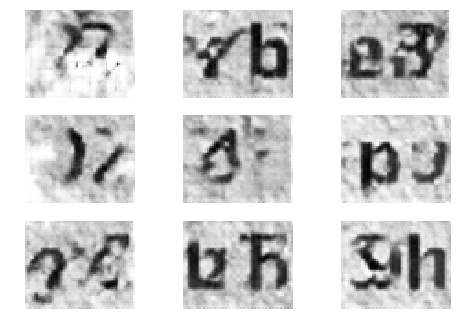

3601 [D loss: 0.810781] [G loss: 1.481158]
3602 [D loss: 0.664998] [G loss: 1.589540]
3603 [D loss: 0.548258] [G loss: 1.827228]
3604 [D loss: 0.610650] [G loss: 1.821177]
3605 [D loss: 0.536110] [G loss: 1.459602]
3606 [D loss: 0.469319] [G loss: 2.056589]
3607 [D loss: 0.682311] [G loss: 1.602287]
3608 [D loss: 0.647213] [G loss: 1.732371]
3609 [D loss: 0.548122] [G loss: 1.905988]
3610 [D loss: 0.676925] [G loss: 1.516994]
3611 [D loss: 0.634904] [G loss: 1.700231]
3612 [D loss: 0.402578] [G loss: 1.682775]
3613 [D loss: 0.512148] [G loss: 1.369885]
3614 [D loss: 0.574496] [G loss: 1.517628]
3615 [D loss: 0.526588] [G loss: 1.737597]
3616 [D loss: 0.479718] [G loss: 2.229465]
3617 [D loss: 0.549553] [G loss: 2.177515]
3618 [D loss: 0.607278] [G loss: 1.742835]
3619 [D loss: 0.632671] [G loss: 1.180653]
3620 [D loss: 0.795212] [G loss: 1.604174]
3621 [D loss: 0.407280] [G loss: 2.575322]
3622 [D loss: 0.432058] [G loss: 2.197885]
3623 [D loss: 0.814084] [G loss: 1.724923]
3624 [D los

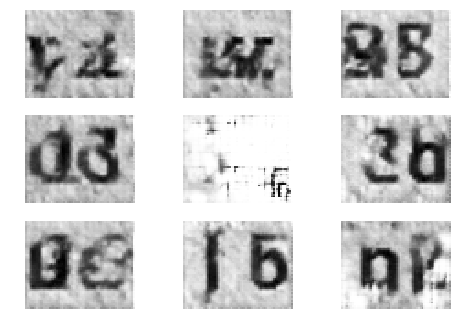

3651 [D loss: 0.576382] [G loss: 1.876795]
3652 [D loss: 0.736675] [G loss: 1.797255]
3653 [D loss: 0.398232] [G loss: 1.228972]
3654 [D loss: 0.692428] [G loss: 1.476532]
3655 [D loss: 0.602335] [G loss: 1.098350]
3656 [D loss: 0.621622] [G loss: 1.593452]
3657 [D loss: 0.523928] [G loss: 2.064928]
3658 [D loss: 0.546205] [G loss: 1.780689]
3659 [D loss: 0.509358] [G loss: 1.280292]
3660 [D loss: 0.632245] [G loss: 1.728081]
3661 [D loss: 0.693217] [G loss: 1.739242]
3662 [D loss: 0.597687] [G loss: 1.737739]
3663 [D loss: 0.705373] [G loss: 1.522756]
3664 [D loss: 0.502787] [G loss: 1.576678]
3665 [D loss: 0.571916] [G loss: 1.702782]
3666 [D loss: 0.748188] [G loss: 1.314510]
3667 [D loss: 0.506411] [G loss: 1.734990]
3668 [D loss: 0.697338] [G loss: 1.892375]
3669 [D loss: 0.618058] [G loss: 2.059280]
3670 [D loss: 0.562811] [G loss: 1.816969]
3671 [D loss: 0.686102] [G loss: 0.859010]
3672 [D loss: 0.831363] [G loss: 1.234659]
3673 [D loss: 0.568445] [G loss: 1.780037]
3674 [D los

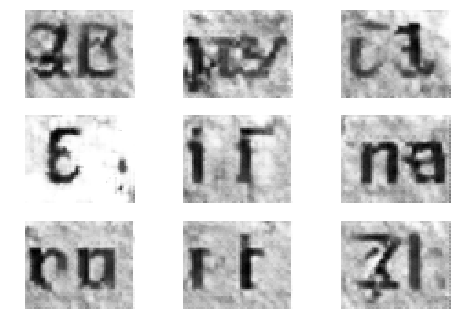

3701 [D loss: 0.520026] [G loss: 2.123211]
3702 [D loss: 0.675228] [G loss: 1.810445]
3703 [D loss: 0.383262] [G loss: 2.030090]
3704 [D loss: 0.504524] [G loss: 2.114367]
3705 [D loss: 0.756894] [G loss: 1.548639]
3706 [D loss: 0.672246] [G loss: 1.678420]
3707 [D loss: 0.687463] [G loss: 1.493558]
3708 [D loss: 0.766823] [G loss: 1.284332]
3709 [D loss: 0.491337] [G loss: 2.006706]
3710 [D loss: 0.660682] [G loss: 1.987215]
3711 [D loss: 0.581793] [G loss: 1.894766]
3712 [D loss: 0.469238] [G loss: 1.744516]
3713 [D loss: 0.820856] [G loss: 1.403344]
3714 [D loss: 0.582054] [G loss: 1.784105]
3715 [D loss: 0.418242] [G loss: 2.220467]
3716 [D loss: 0.460321] [G loss: 2.039432]
3717 [D loss: 0.440252] [G loss: 2.047476]
3718 [D loss: 0.705515] [G loss: 1.631010]
3719 [D loss: 0.485737] [G loss: 1.275652]
3720 [D loss: 0.646433] [G loss: 1.673605]
3721 [D loss: 0.768813] [G loss: 1.719138]
3722 [D loss: 0.591431] [G loss: 1.660243]
3723 [D loss: 0.546708] [G loss: 1.530894]
3724 [D los

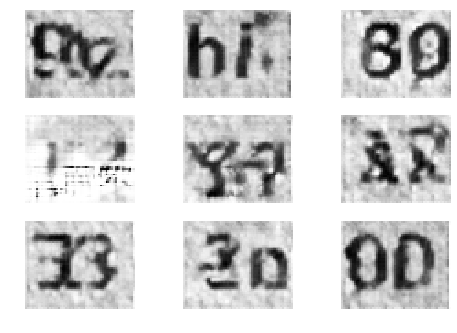

3751 [D loss: 0.484885] [G loss: 1.879177]
3752 [D loss: 0.600436] [G loss: 1.869767]
3753 [D loss: 0.540020] [G loss: 2.054350]
3754 [D loss: 0.728688] [G loss: 1.365223]
3755 [D loss: 0.659378] [G loss: 1.382061]
3756 [D loss: 0.793266] [G loss: 1.758548]
3757 [D loss: 0.537234] [G loss: 1.947581]
3758 [D loss: 0.511961] [G loss: 1.589278]
3759 [D loss: 0.574144] [G loss: 1.801879]
3760 [D loss: 0.393587] [G loss: 1.446808]
3761 [D loss: 0.413230] [G loss: 1.523811]
3762 [D loss: 0.523829] [G loss: 1.824462]
3763 [D loss: 0.950345] [G loss: 1.388184]
3764 [D loss: 0.582633] [G loss: 1.332501]
3765 [D loss: 0.528520] [G loss: 1.989912]
3766 [D loss: 0.840157] [G loss: 1.534344]
3767 [D loss: 0.611410] [G loss: 2.234596]
3768 [D loss: 0.596901] [G loss: 1.493441]
3769 [D loss: 0.569718] [G loss: 1.772904]
3770 [D loss: 0.418212] [G loss: 1.644257]
3771 [D loss: 0.642912] [G loss: 1.621543]
3772 [D loss: 0.565235] [G loss: 1.970431]
3773 [D loss: 0.570693] [G loss: 1.681509]
3774 [D los

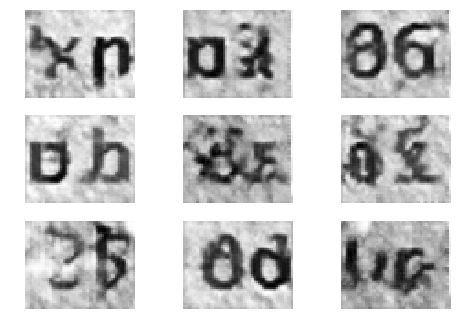

3801 [D loss: 0.809928] [G loss: 1.633603]
3802 [D loss: 0.399909] [G loss: 1.839797]
3803 [D loss: 0.551584] [G loss: 1.953781]
3804 [D loss: 0.348321] [G loss: 2.041775]
3805 [D loss: 0.491322] [G loss: 1.734109]
3806 [D loss: 0.578440] [G loss: 1.738844]
3807 [D loss: 0.387650] [G loss: 2.047561]
3808 [D loss: 0.639813] [G loss: 2.203956]
3809 [D loss: 0.425031] [G loss: 2.051541]
3810 [D loss: 0.746734] [G loss: 1.828719]
3811 [D loss: 0.628521] [G loss: 1.481691]
3812 [D loss: 0.564117] [G loss: 1.755538]
3813 [D loss: 0.683524] [G loss: 1.607416]
3814 [D loss: 0.401028] [G loss: 2.313537]
3815 [D loss: 0.487533] [G loss: 2.045831]
3816 [D loss: 0.523852] [G loss: 1.895311]
3817 [D loss: 0.404905] [G loss: 2.317150]
3818 [D loss: 0.792962] [G loss: 1.325606]
3819 [D loss: 0.406251] [G loss: 2.163995]
3820 [D loss: 0.727575] [G loss: 1.253730]
3821 [D loss: 0.459110] [G loss: 1.674953]
3822 [D loss: 0.437544] [G loss: 2.624531]
3823 [D loss: 0.697817] [G loss: 1.604568]
3824 [D los

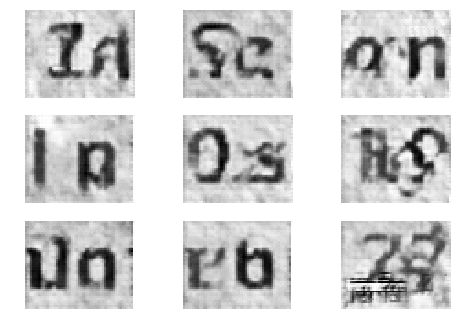

3851 [D loss: 0.523076] [G loss: 1.676939]
3852 [D loss: 0.635294] [G loss: 1.705375]
3853 [D loss: 0.542972] [G loss: 1.873677]
3854 [D loss: 0.414677] [G loss: 2.071663]
3855 [D loss: 0.951600] [G loss: 1.304533]
3856 [D loss: 0.662146] [G loss: 1.387079]
3857 [D loss: 0.742307] [G loss: 1.531878]
3858 [D loss: 0.676358] [G loss: 1.371791]
3859 [D loss: 0.656747] [G loss: 1.706382]
3860 [D loss: 0.520959] [G loss: 2.121860]
3861 [D loss: 0.748846] [G loss: 2.006575]
3862 [D loss: 0.751209] [G loss: 1.492251]
3863 [D loss: 0.558813] [G loss: 1.888296]
3864 [D loss: 0.725102] [G loss: 1.489470]
3865 [D loss: 0.437188] [G loss: 1.200931]
3866 [D loss: 0.528279] [G loss: 1.630182]
3867 [D loss: 0.522994] [G loss: 1.959469]
3868 [D loss: 0.502540] [G loss: 2.144617]
3869 [D loss: 0.548761] [G loss: 1.607713]
3870 [D loss: 0.447350] [G loss: 1.455122]
3871 [D loss: 0.434349] [G loss: 1.726853]
3872 [D loss: 0.456103] [G loss: 1.853111]
3873 [D loss: 0.640879] [G loss: 1.944423]
3874 [D los

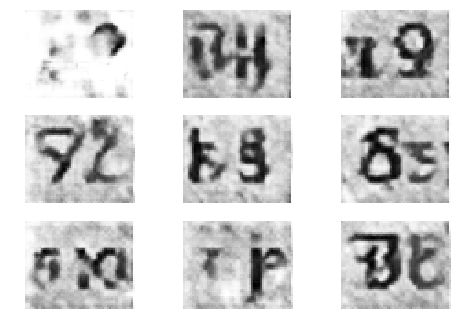

3901 [D loss: 0.758670] [G loss: 1.723475]
3902 [D loss: 0.603470] [G loss: 2.100102]
3903 [D loss: 0.480880] [G loss: 2.043731]
3904 [D loss: 0.767707] [G loss: 1.896872]
3905 [D loss: 0.686235] [G loss: 1.271573]
3906 [D loss: 0.457624] [G loss: 1.860416]
3907 [D loss: 0.528692] [G loss: 2.175105]
3908 [D loss: 0.593548] [G loss: 1.791113]
3909 [D loss: 0.454591] [G loss: 2.358361]
3910 [D loss: 0.447405] [G loss: 1.932654]
3911 [D loss: 0.372991] [G loss: 2.491063]
3912 [D loss: 0.700697] [G loss: 1.406550]
3913 [D loss: 0.521178] [G loss: 2.068033]
3914 [D loss: 0.932111] [G loss: 1.382493]
3915 [D loss: 0.751852] [G loss: 1.391556]
3916 [D loss: 0.365273] [G loss: 1.621266]
3917 [D loss: 0.537397] [G loss: 1.608126]
3918 [D loss: 0.606473] [G loss: 1.558396]
3919 [D loss: 0.456276] [G loss: 1.273782]
3920 [D loss: 0.454554] [G loss: 1.643340]
3921 [D loss: 0.550259] [G loss: 1.304798]
3922 [D loss: 0.481816] [G loss: 1.520539]
3923 [D loss: 0.433352] [G loss: 2.048808]
3924 [D los

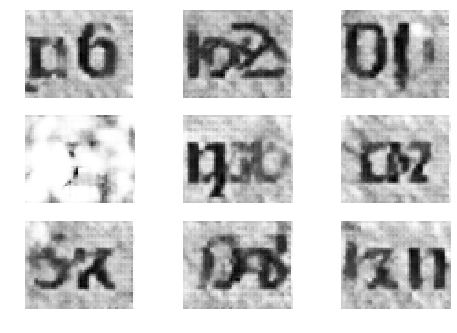

3951 [D loss: 0.613656] [G loss: 2.012408]
3952 [D loss: 0.499736] [G loss: 2.031516]
3953 [D loss: 0.511157] [G loss: 2.351002]
3954 [D loss: 0.664179] [G loss: 1.527382]
3955 [D loss: 0.493486] [G loss: 1.805526]
3956 [D loss: 0.637396] [G loss: 1.544496]
3957 [D loss: 0.491714] [G loss: 2.114150]
3958 [D loss: 0.759399] [G loss: 2.121364]
3959 [D loss: 0.918652] [G loss: 1.546254]
3960 [D loss: 0.575196] [G loss: 1.775743]
3961 [D loss: 0.429394] [G loss: 1.948432]
3962 [D loss: 0.325986] [G loss: 2.264805]
3963 [D loss: 0.563793] [G loss: 1.747459]
3964 [D loss: 0.808983] [G loss: 1.181796]
3965 [D loss: 0.343262] [G loss: 1.849937]
3966 [D loss: 0.507887] [G loss: 1.567334]
3967 [D loss: 0.418940] [G loss: 1.284759]
3968 [D loss: 0.350829] [G loss: 1.696624]
3969 [D loss: 0.447263] [G loss: 1.887981]
3970 [D loss: 0.549330] [G loss: 1.258900]
3971 [D loss: 0.569340] [G loss: 1.773758]
3972 [D loss: 0.357812] [G loss: 1.984282]
3973 [D loss: 0.379072] [G loss: 2.017434]
3974 [D los

In [20]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=50, data_set = data_set)